# Trajectories of the electrification of vehicles in the world

In this notebook, I try to look for an overarching pattern in the electrification of the worlds vehicle sales.

### Imports and various tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from utils import correlate_slice_normalized, df_shift_index, frequency_in_year, delta_frequency_to_string
from IPython.display import display

%load_ext autoreload
%autoreload 2

import world_ev_data as ev

In [2]:
e_car_sales = ev.robbie_andrew_data()
e_car_sales

sales_bevs  Diesel  Ethanol  Ethanol_Petrol  Gasoline  \
Country YYYYMM                                                              
Albania 2019-01-01         1.0  2416.0      NaN             NaN       NaN   
        2019-02-01         1.0  2708.0      NaN             NaN       NaN   
        2019-03-01         3.0  1374.0      NaN             NaN       NaN   
        2019-04-01         2.0  2010.0      NaN             NaN       NaN   
        2019-05-01         0.0  2735.0      NaN             NaN       NaN   
...                        ...     ...      ...             ...       ...   
Uruguay 2025-03-01       475.0    37.0      NaN             NaN       NaN   
        2025-04-01       489.0    14.0      NaN             NaN       NaN   
        2025-05-01       594.0    25.0      NaN             NaN       NaN   
        2025-06-01       373.0    38.0      NaN             NaN       NaN   
        2025-07-01       601.0    24.0      NaN             NaN       NaN   

                    Hybrid  Hydrogen  ICE  InternalCombustion  LPG  ...  \
Country YYYYMM                                                      ...   
Albania 2019-01-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-02-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-03-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-04-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-05-01     NaN       NaN  NaN                 NaN  NaN  ...   
...                    ...       ...  ...                 ...  ...  ...   
Uruguay 2025-03-01   165.0       NaN  NaN                 NaN  NaN  ...   
        2025-04-01    50.0       NaN  NaN                 NaN  NaN  ...   
        2025-05-01    24.0       NaN  NaN                 NaN  NaN  ...   
        2025-06-01    31.0       NaN  NaN                 NaN  NaN  ...   
        2025-07-01   210.0       NaN  NaN                 NaN  NaN  ...   

                    Other  Others  Petrol  PetrolBlend  sales_phevs  \
Country YYYYMM                                                        
Albania 2019-01-01    NaN     0.0   412.0          NaN          0.0   
        2019-02-01    NaN     0.0   599.0          NaN          0.0   
        2019-03-01    NaN     0.0   238.0          NaN          0.0   
        2019-04-01    NaN     0.0   335.0          NaN          0.0   
        2019-05-01    NaN     0.0   477.0          NaN          0.0   
...                   ...     ...     ...          ...          ...   
Uruguay 2025-03-01    NaN     NaN  1683.0          NaN          NaN   
        2025-04-01    NaN     NaN  1274.0          NaN          NaN   
        2025-05-01    NaN     NaN  1432.0          NaN          NaN   
        2025-06-01    NaN     NaN  1227.0          NaN          NaN   
        2025-07-01    NaN     NaN  1335.0          NaN          NaN   

                    sales_total  sales_share_bevs  sales_share_phevs  \
Country YYYYMM                                                         
Albania 2019-01-01       3093.0          0.000323                0.0   
        2019-02-01       3660.0          0.000273                0.0   
        2019-03-01       1752.0          0.001712                0.0   
        2019-04-01       2582.0          0.000775                0.0   
        2019-05-01       3578.0          0.000000                0.0   
...                         ...               ...                ...   
Uruguay 2025-03-01       2360.0          0.201271                NaN   
        2025-04-01       1827.0          0.267652                NaN   
        2025-05-01       2075.0          0.286265                NaN   
        2025-06-01       1669.0          0.223487                NaN   
        2025-07-01       2170.0          0.276959                NaN   

                    sales_share_evs  entity_type  
Country YYYYMM                                    
Albania 2019-01-01         0.000323      Country  
        2019-02-01         0

In [3]:
# Test e_car_sales
#e_car_sales.index.get_level_values(1) > '2005'

e_car_sales[ev.SALES_SHARE_EVS].xs('2023', level=1)


Country  YYYYMM    
Albania  2023-01-01    0.010447
         2023-02-01    0.036774
         2023-03-01    0.031501
         2023-04-01    0.025524
         2023-05-01    0.028870
                         ...   
Uruguay  2023-08-01    0.056781
         2023-09-01    0.026685
         2023-10-01    0.030075
         2023-11-01    0.049627
         2023-12-01    0.036028
Name: sales_share_evs, Length: 684, dtype: float64

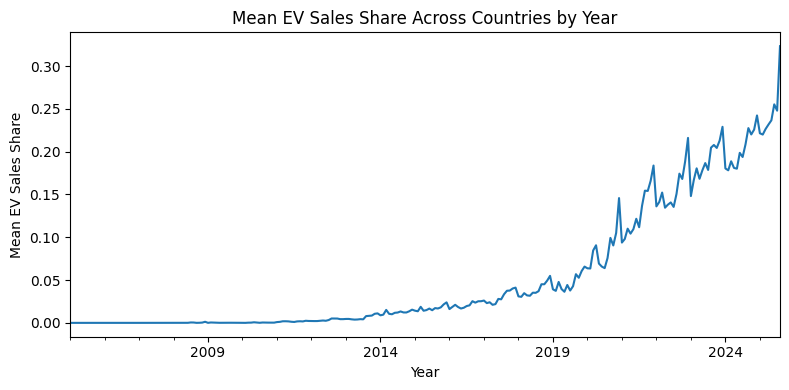

In [4]:
# Calculate mean ev_sales_share across countries for each year
ev_sales_share_mean = (
    e_car_sales[ev.SALES_SHARE_EVS]
    .groupby(level=1)
    .mean()
    .sort_index()
    .to_frame(name='mean_ev_sales_share')
)

# Display the aggregated data
ev_sales_share_mean

# Plot the yearly mean ev_sales_share
ax = ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Mean EV Sales Share Across Countries by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean EV Sales Share')
plt.tight_layout()
plt.show()


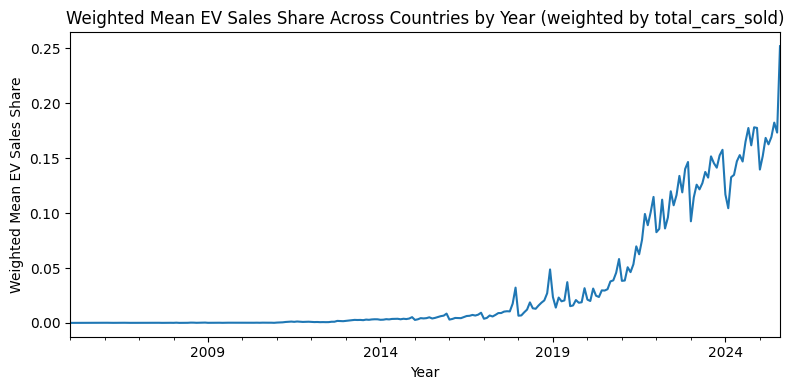

In [5]:
only_countries = e_car_sales[ev.ENTITY_TYPE] == ev.EntityType.Country

weighted_ev_sales_share_mean = (
        (e_car_sales[only_countries][ev.SALES_SHARE_BEVS] * e_car_sales[only_countries][ev.SALES_TOTAL])
        .groupby(level=1)
        .sum()
        /
        e_car_sales[only_countries][ev.SALES_TOTAL].groupby(level=1).sum()
).sort_index().to_frame(name='weighted_mean_ev_sales_share')

weighted_ev_sales_share_mean

ax = weighted_ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Weighted Mean EV Sales Share Across Countries by Year (weighted by total_cars_sold)')
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Mean EV Sales Share')
plt.tight_layout()
plt.show()

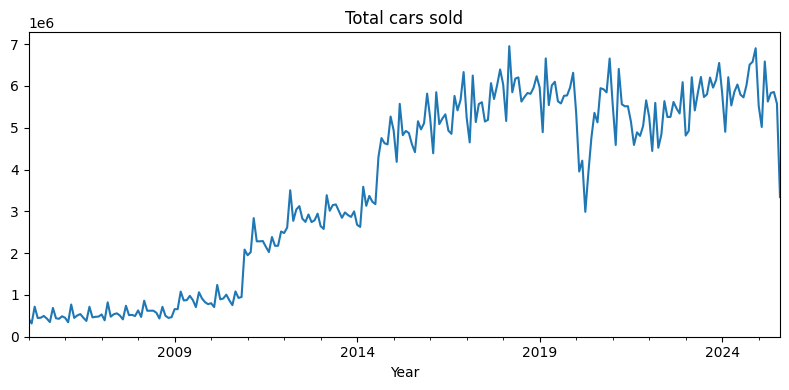

In [6]:


ax = e_car_sales[only_countries][ev.SALES_TOTAL].groupby(level=1).sum().plot(figsize=(8, 4), legend=False)
ax.set_title('Total cars sold')
ax.set_xlabel('Year')
ax.set_ylim(0)
plt.tight_layout()
plt.show()


if 'World' in e_car_sales.index.get_level_values(0):
    ax = e_car_sales.loc['World'][ev.SALES_TOTAL].plot(figsize=(8, 4), legend=False)
    ax.set_title('Total cars sold')
    ax.set_xlabel('Year')
    ax.set_ylim(0)
    plt.tight_layout()
    plt.show()

In [7]:

if 'World' in e_car_sales.index.get_level_values(0):
    ax = e_car_sales.loc['World'][ev.SALES_SHARE_BEVS].plot(figsize=(8, 4), legend=False)
    ax.set_title('EV Sales Share')
    ax.set_xlabel('Year')
    ax.set_ylabel('EV Sales Share')
    plt.tight_layout()
    plt.show()

Time shift of all the countries (how many years they are ahead / behind the average transition)


{'Albania': -55,
 'Australia': -30,
 'Austria': 7,
 'Belgium': 13,
 'Brazil': -59,
 'Bulgaria': -42,
 'California': 6,
 'Canada': -19,
 'Chile': -79,
 'China': 18,
 'Colombia': -53,
 'Croatia': -43,
 'Cyprus': -28,
 'Czechia': -51,
 'Denmark': 30,
 'Estonia': -29,
 'Finland': 28,
 'France': 5,
 'Germany': 14,
 'Greece': -30,
 'Hungary': -28,
 'Iceland': 49,
 'India': -61,
 'Indonesia': -36,
 'Ireland': 16,
 'Israel': 6,
 'Italy': -29,
 'Japan': -64,
 'Latvia': -27,
 'Lithuania': -29,
 'Luxembourg': 15,
 'Malaysia': -60,
 'Malta': 13,
 'Mexico': -76,
 'Netherlands': 17,
 'New Zealand': -28,
 'Norway': 96,
 'Poland': -39,
 'Portugal': 6,
 'Romania': -30,
 'Singapore': -1,
 'Slovakia': -46,
 'Slovenia': -28,
 'Spain': -28,
 'Sweden': 38,
 'Switzerland': 14,
 'Taiwan': -30,
 'Thailand': -20,
 'Turkey': -24,
 'USA': -28,
 'United Kingdom': 6,
 'Uruguay': -18}

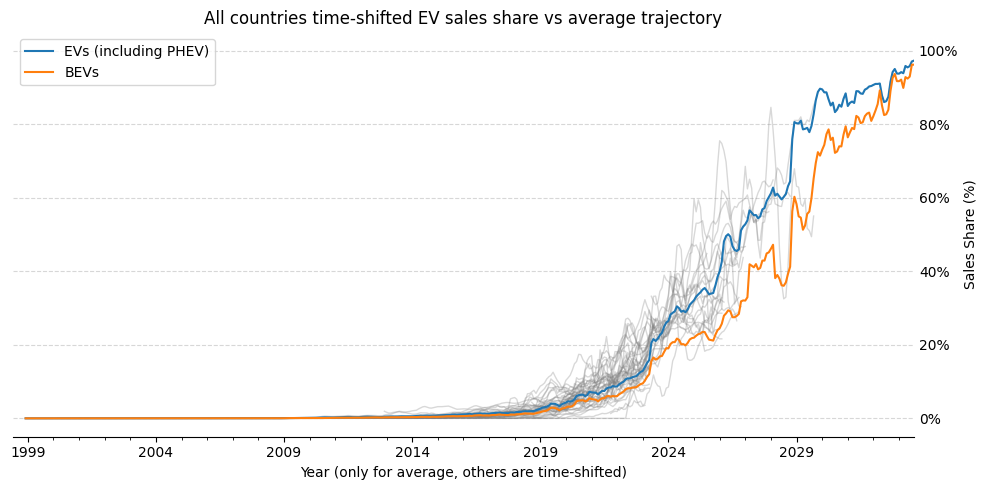

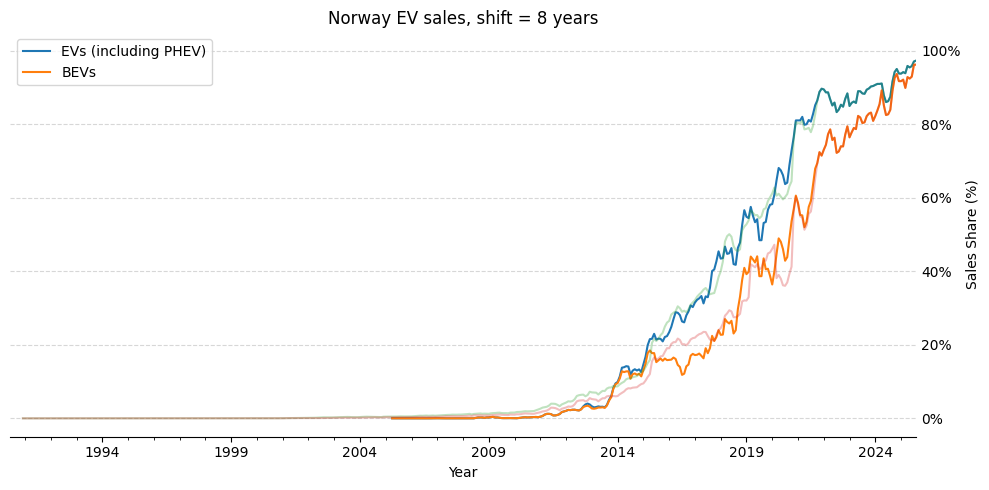

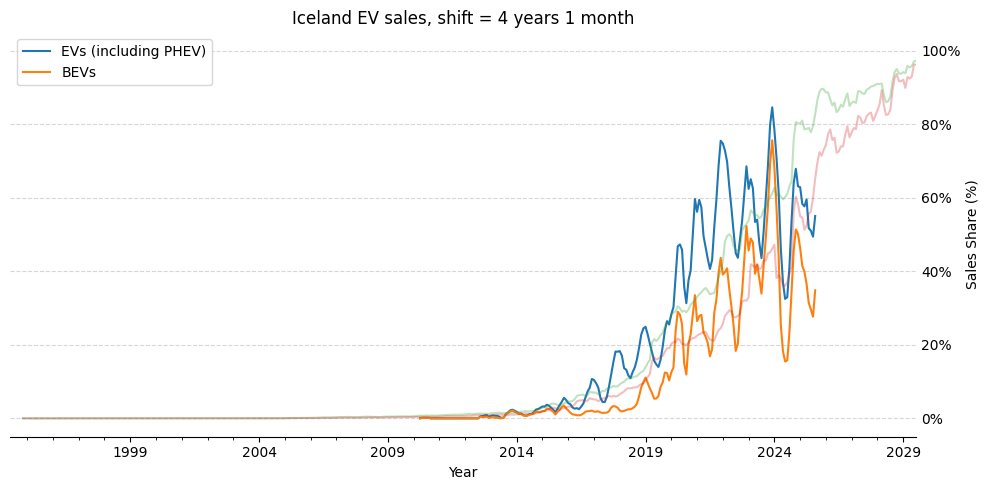

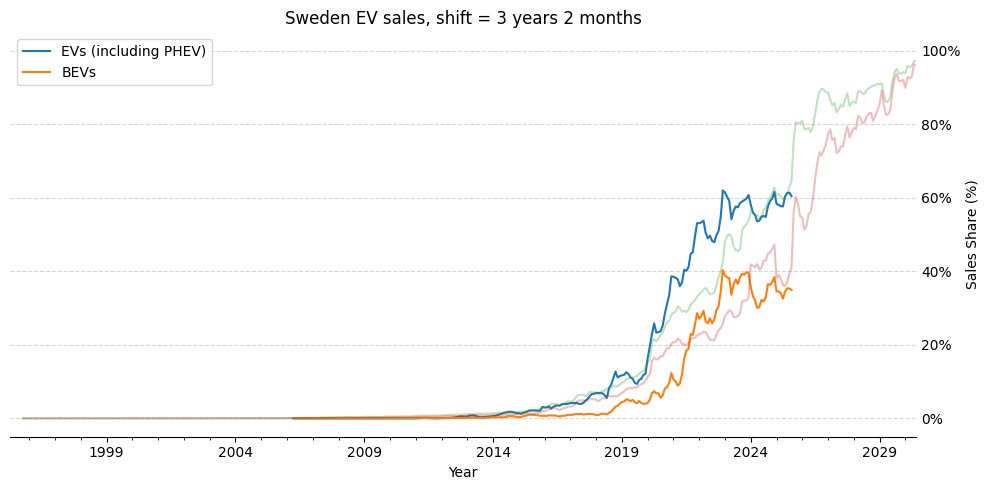

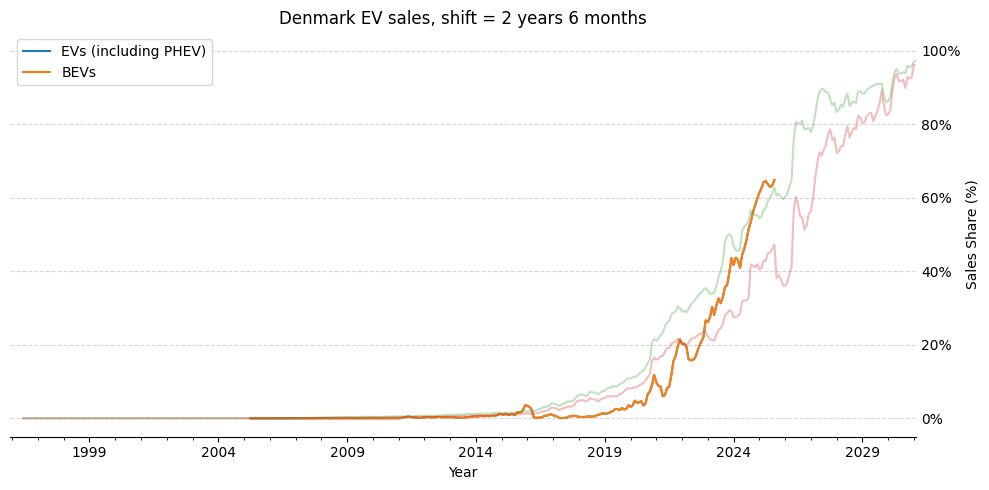

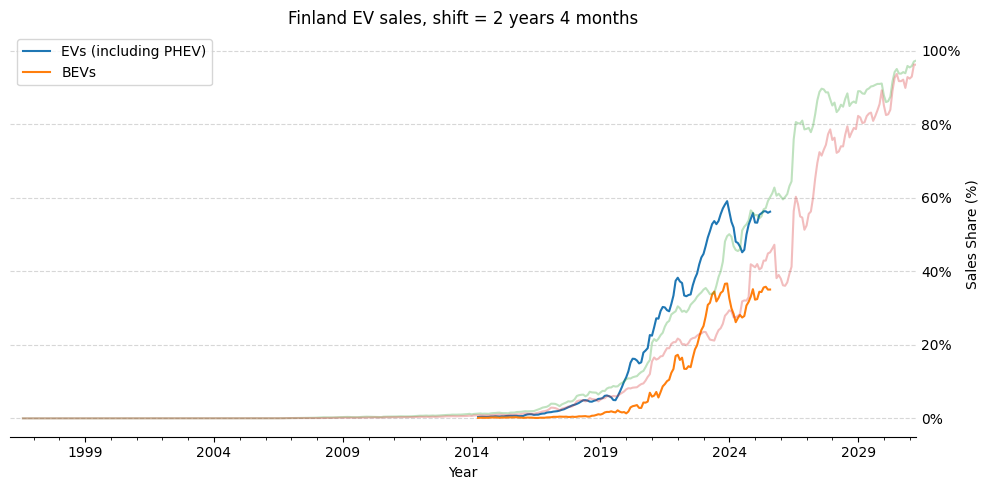

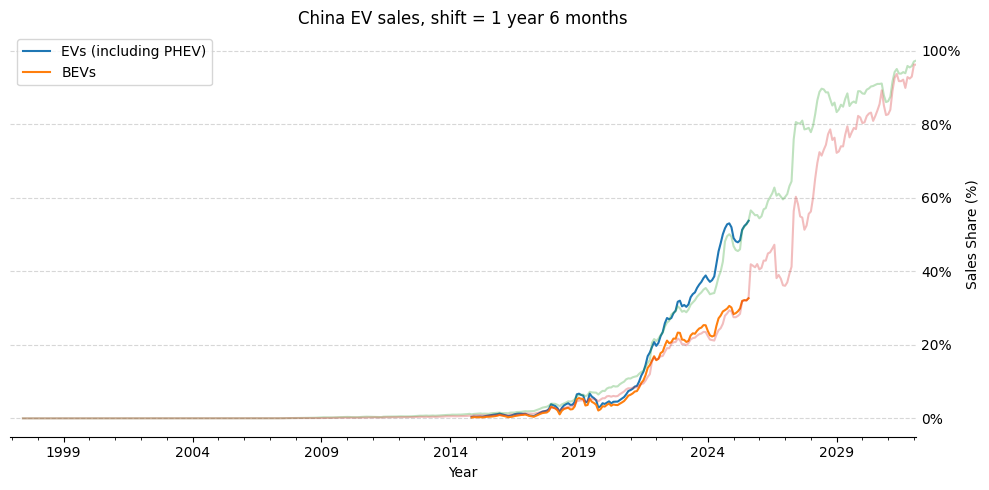

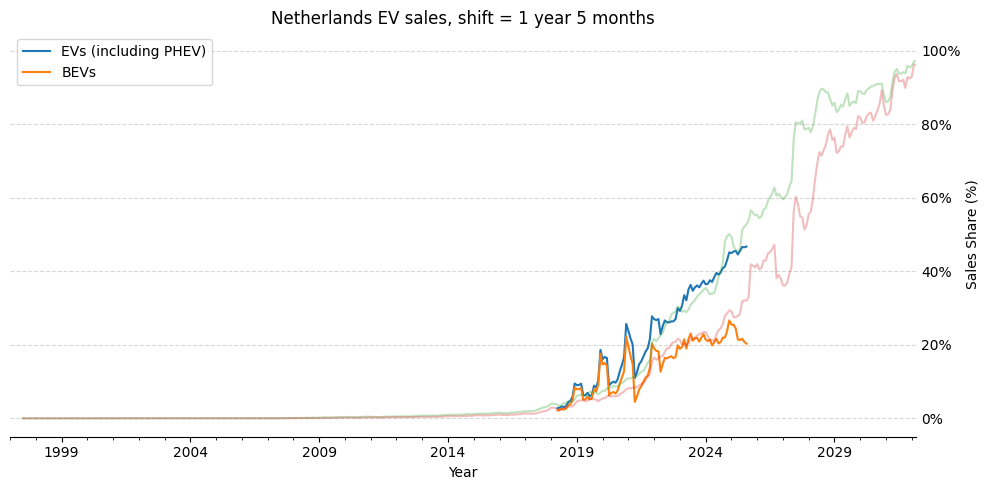

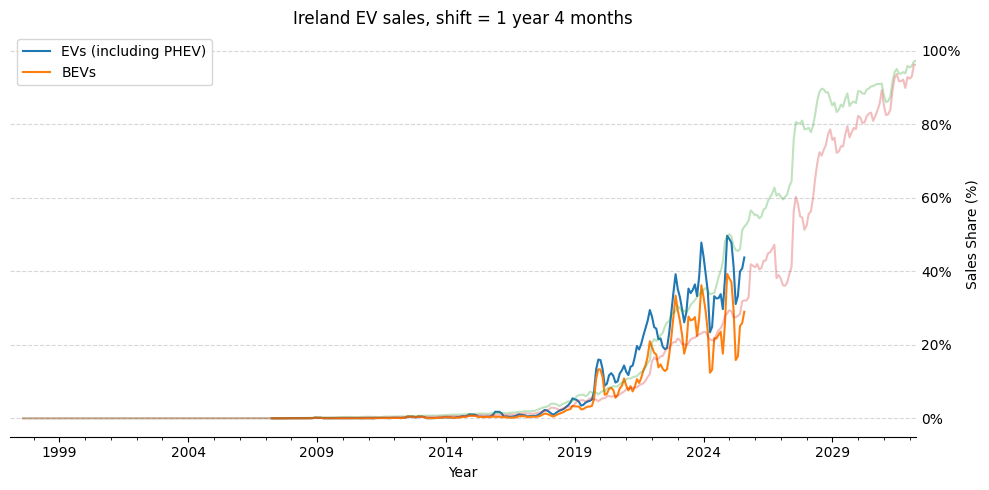

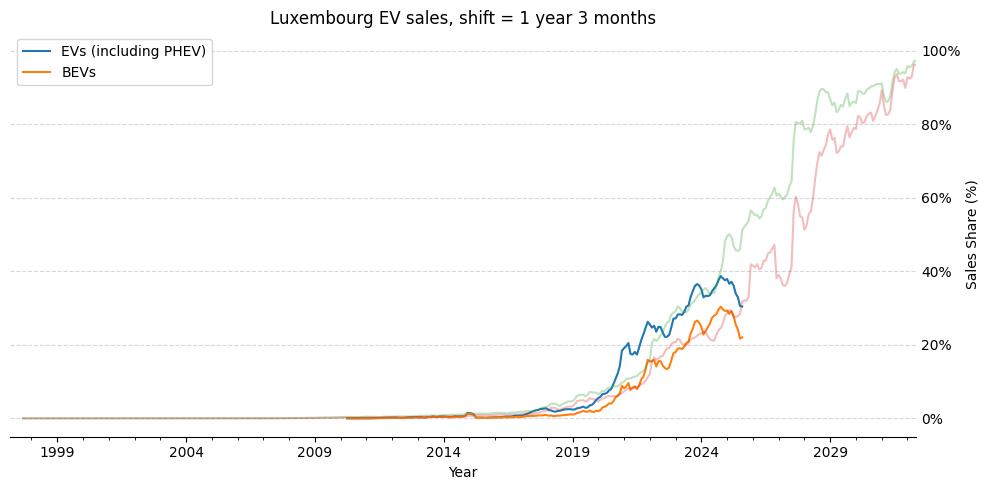

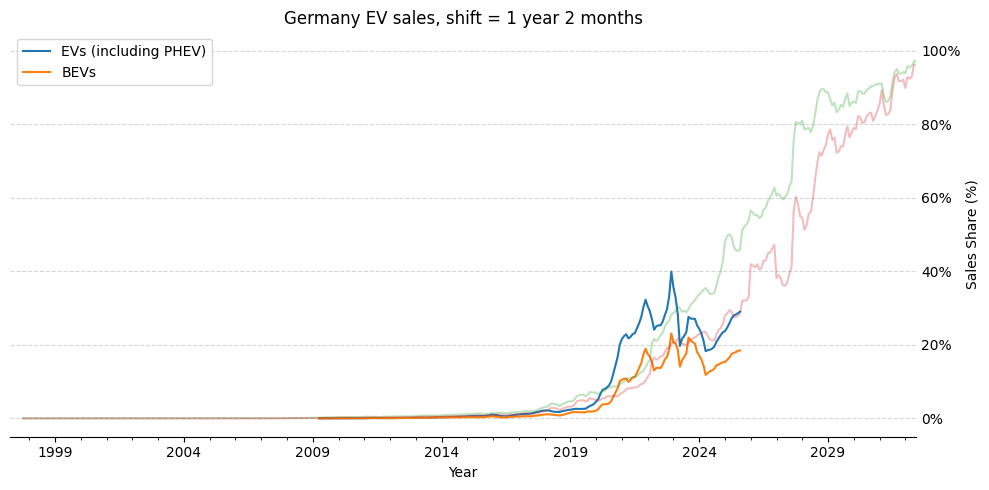

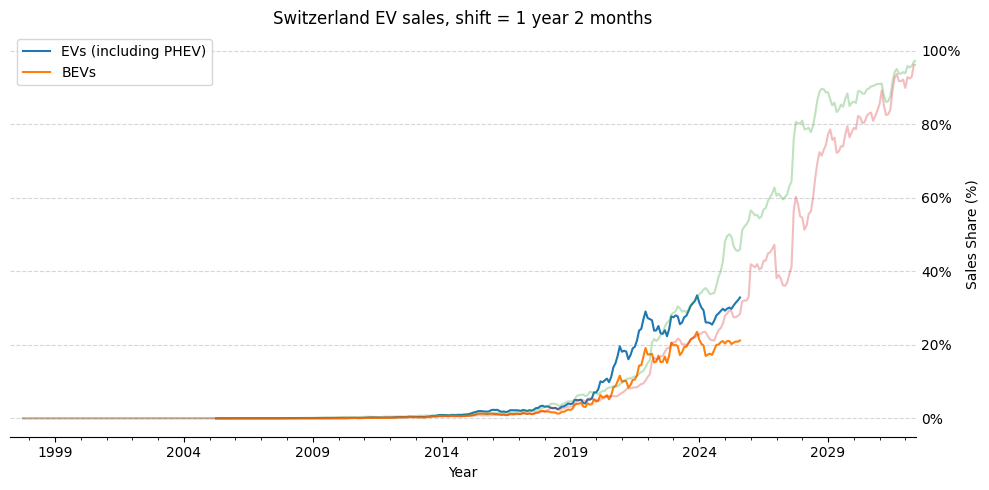

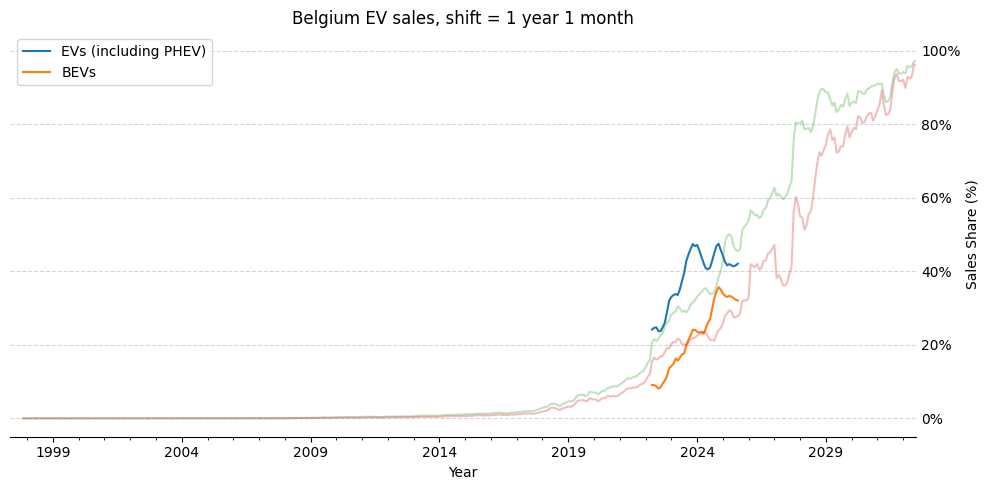

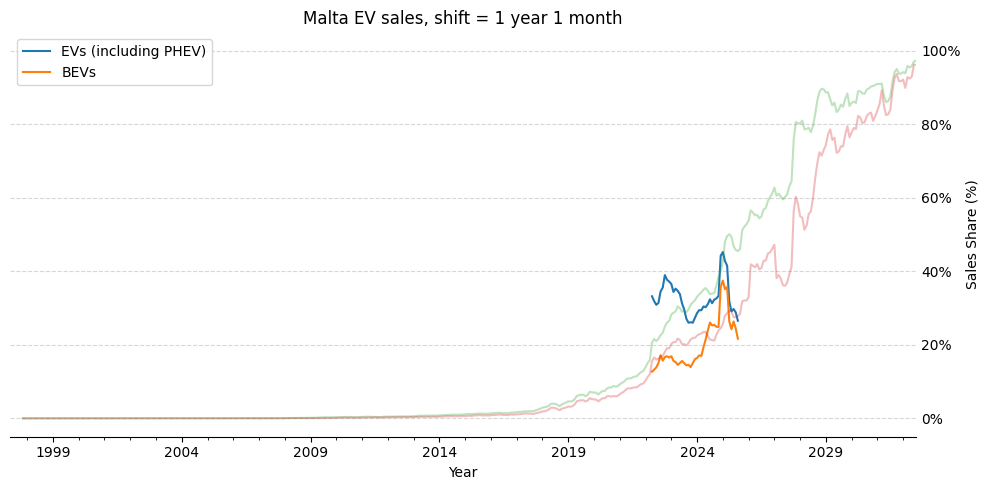

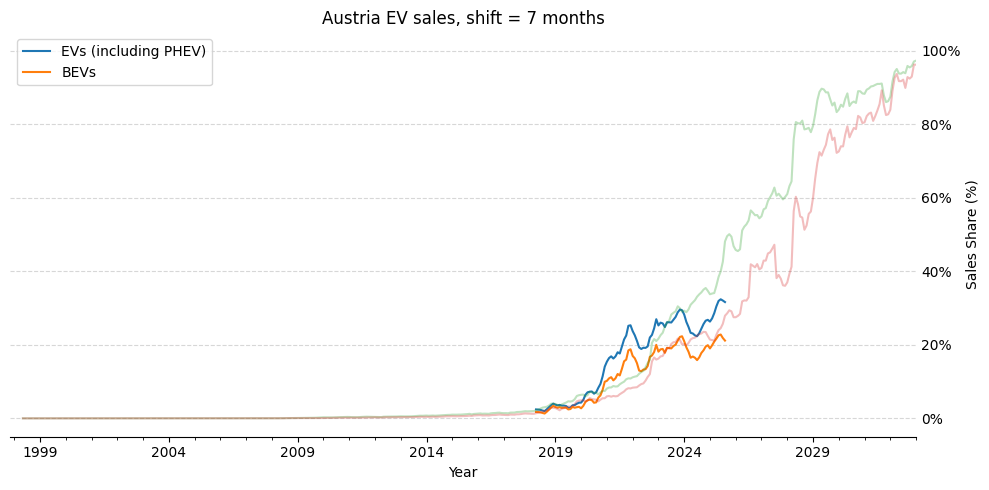

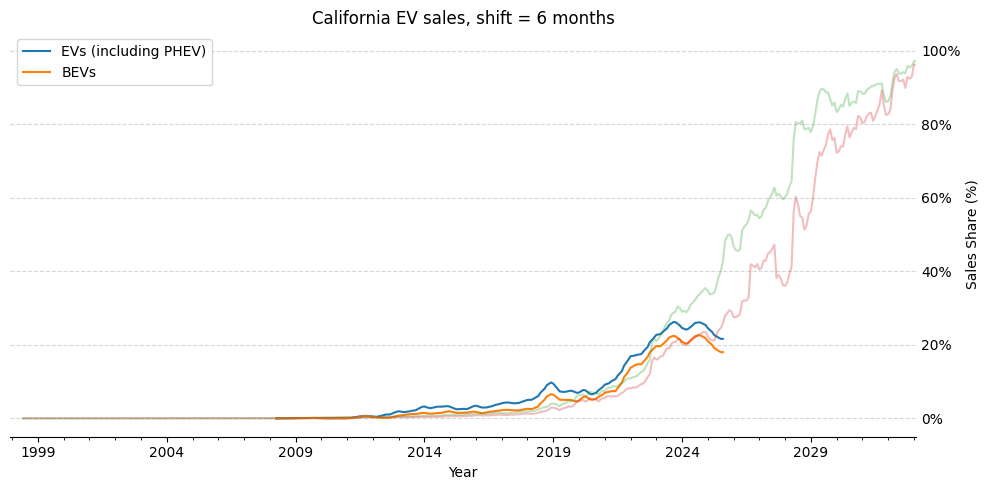

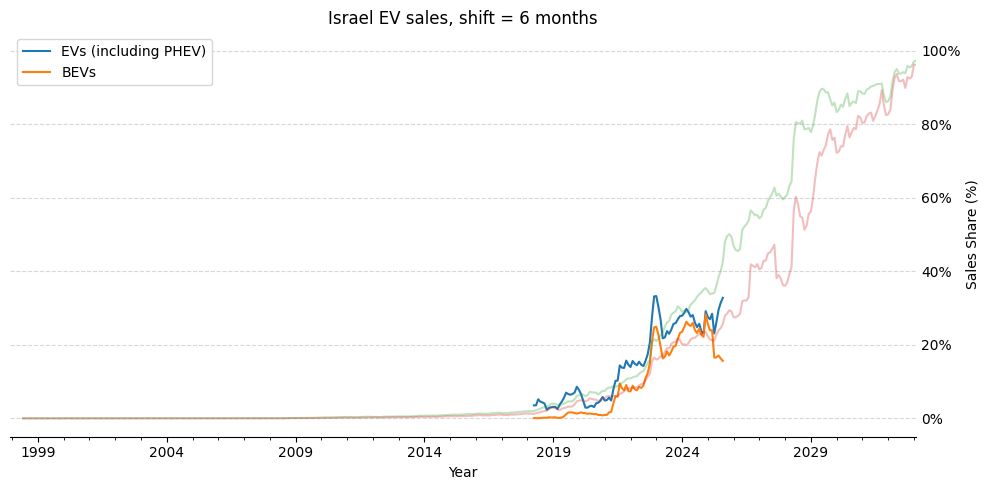

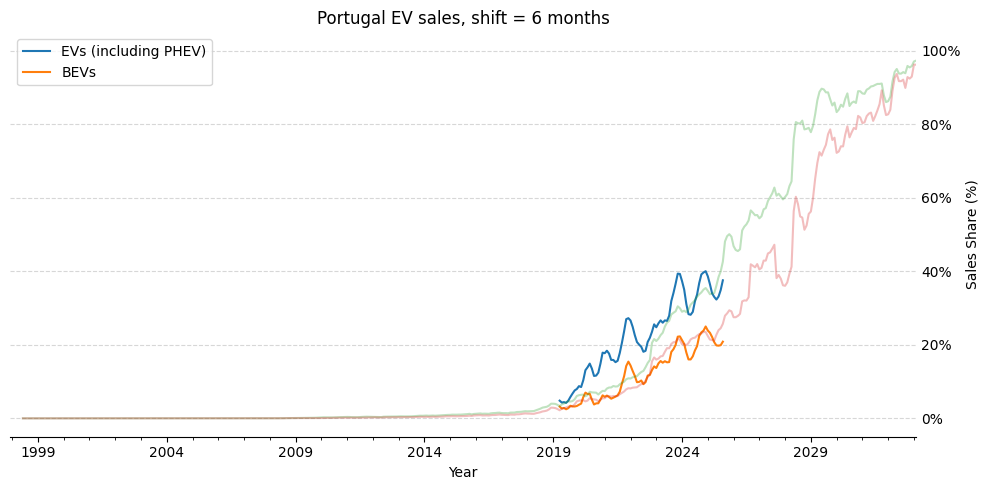

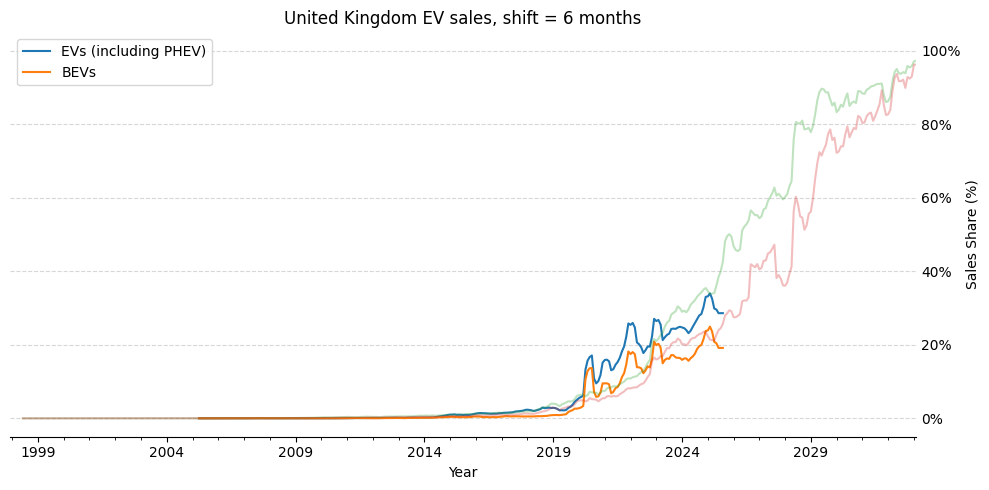

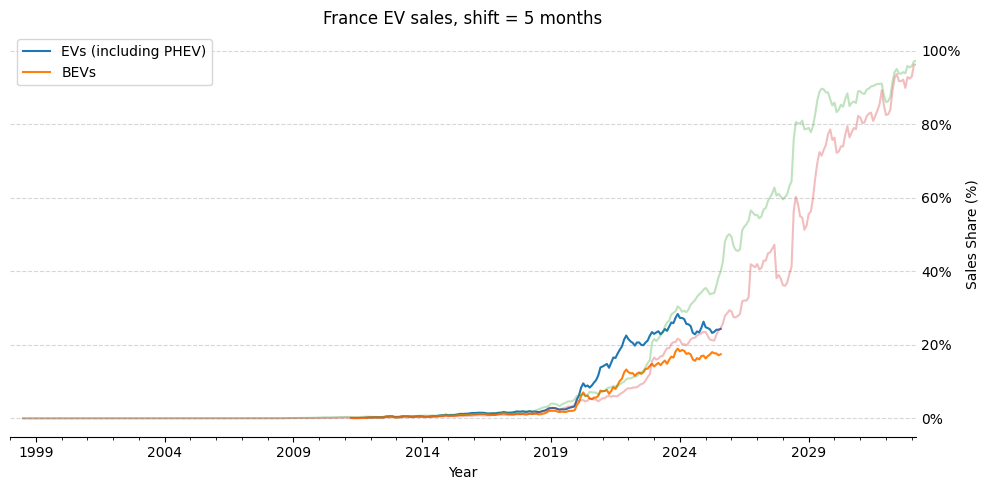

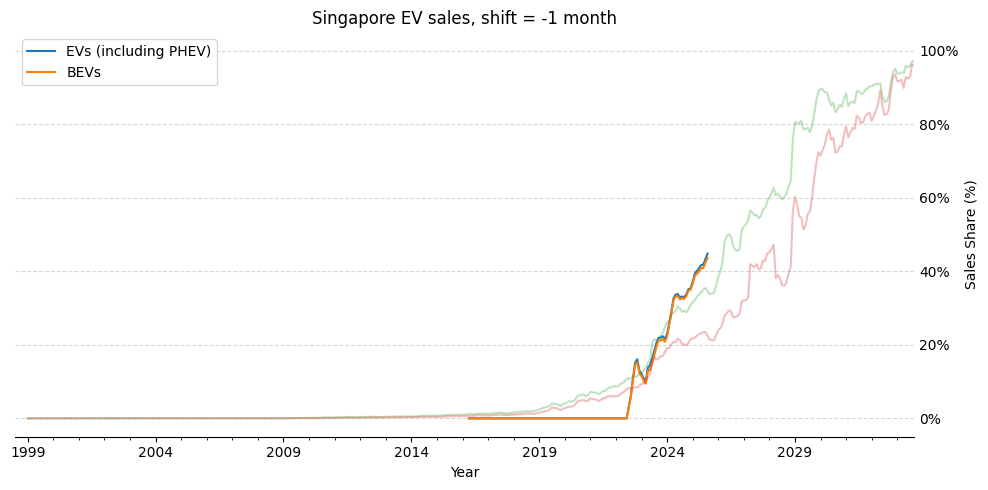

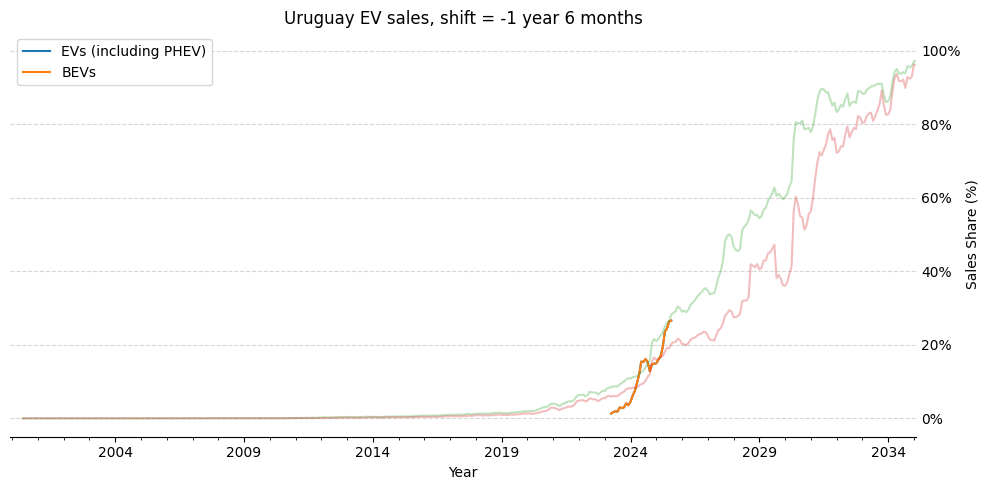

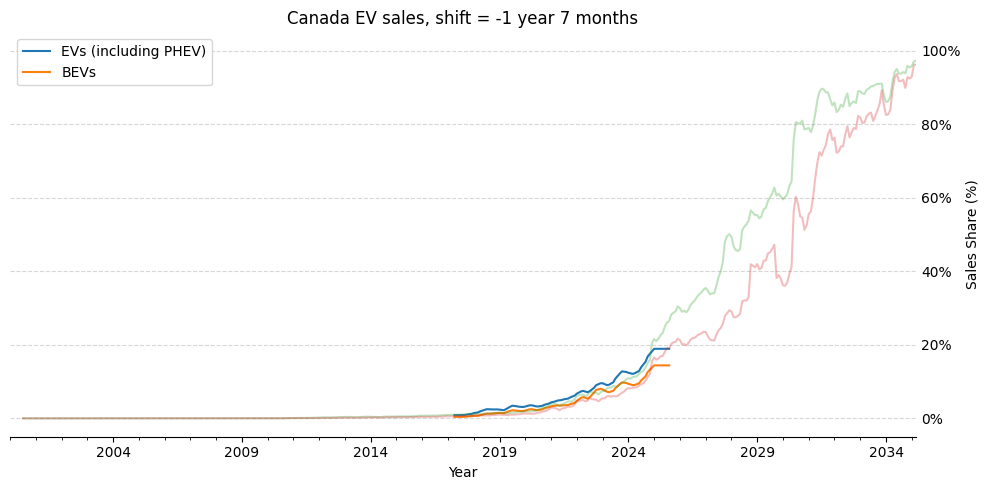

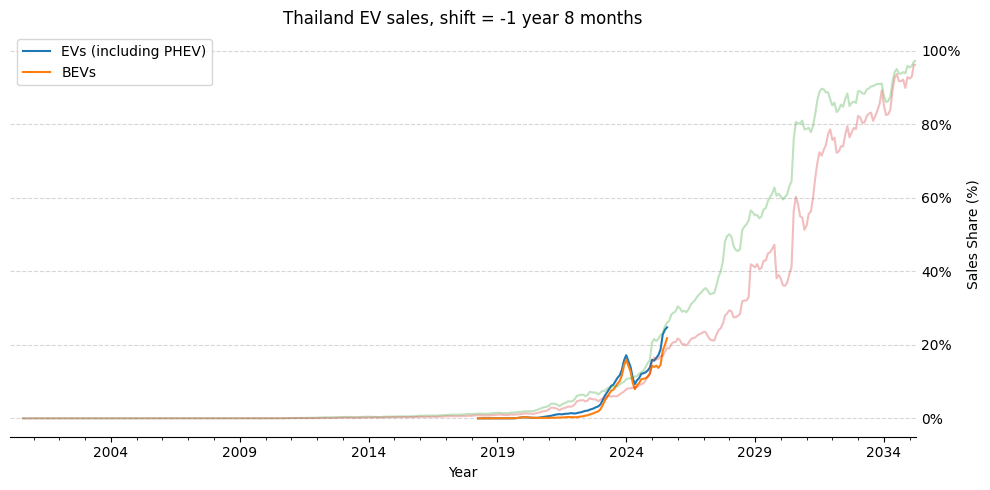

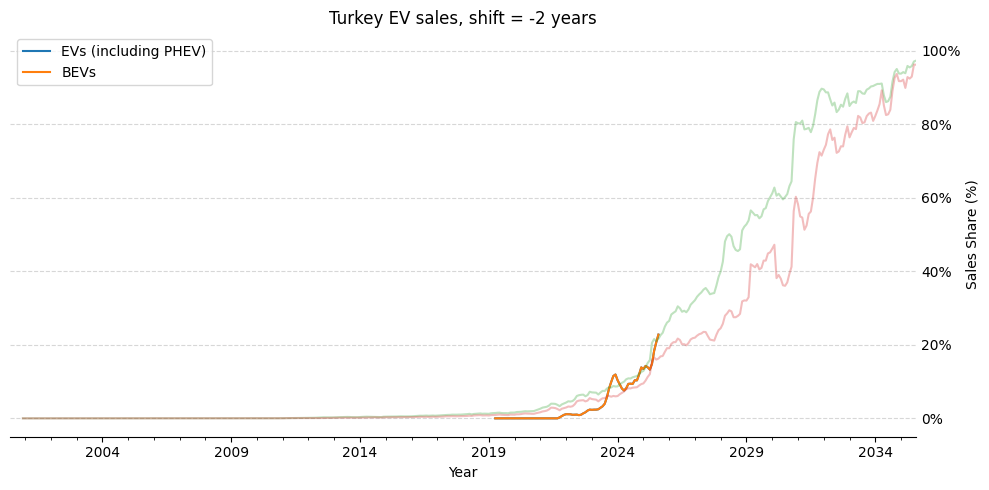

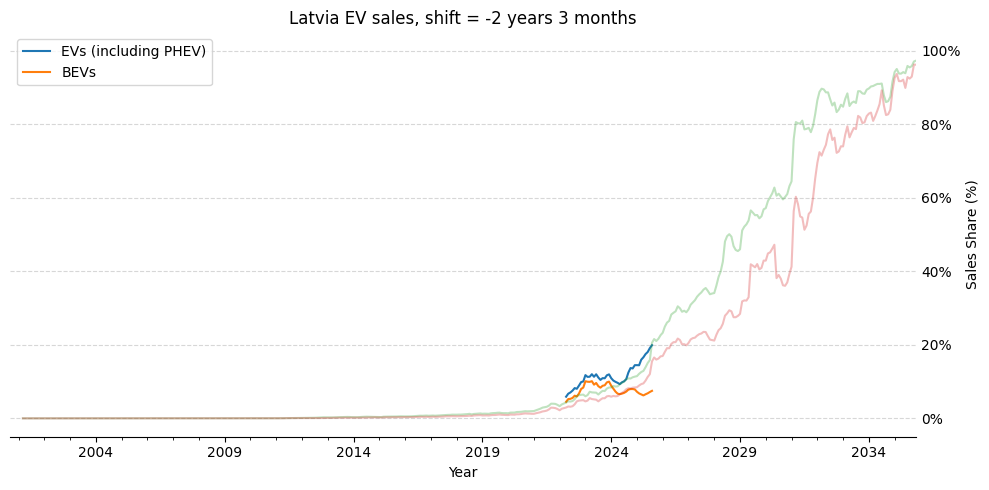

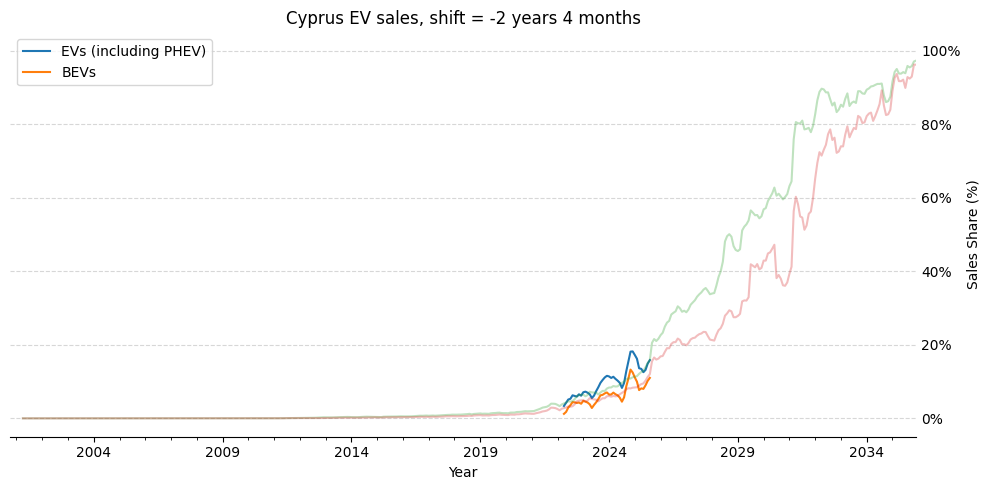

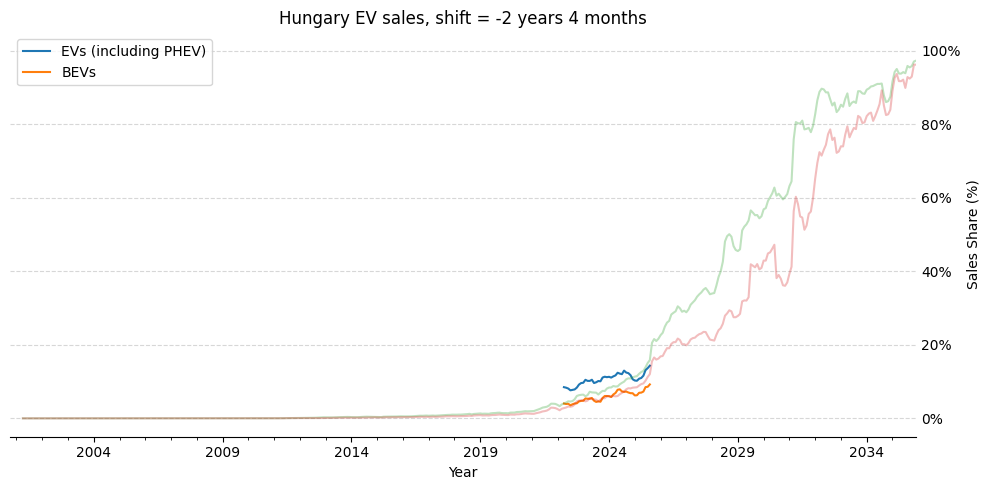

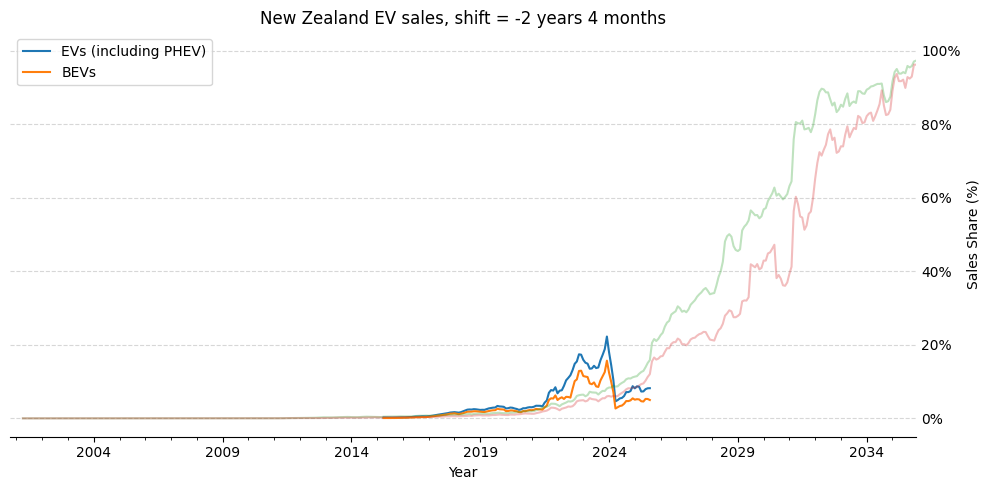

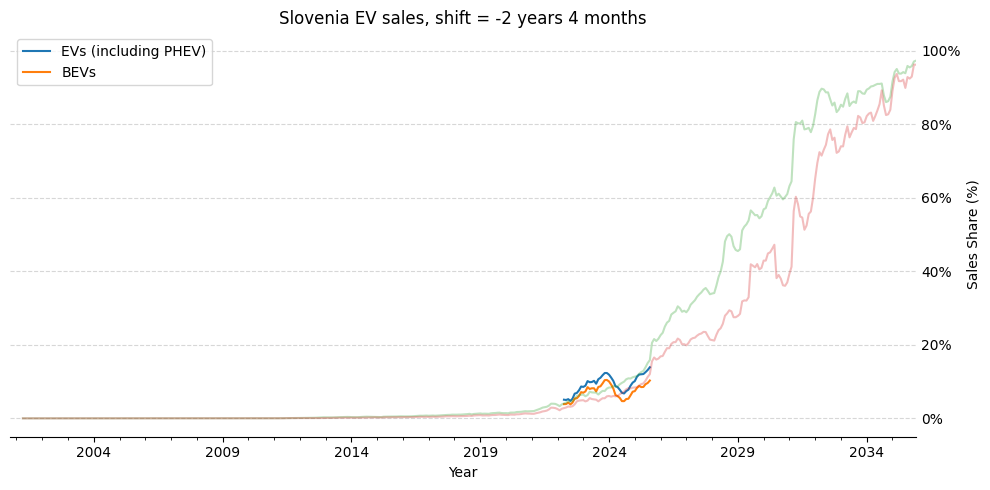

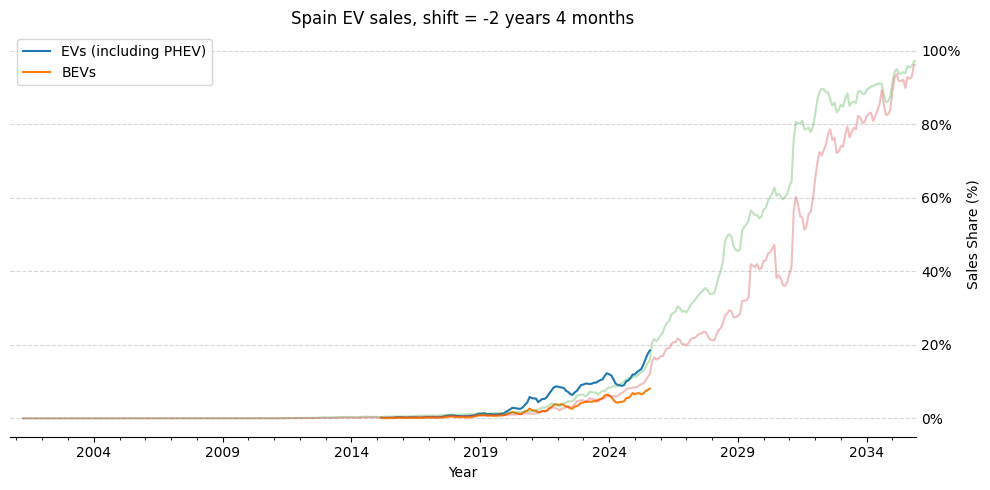

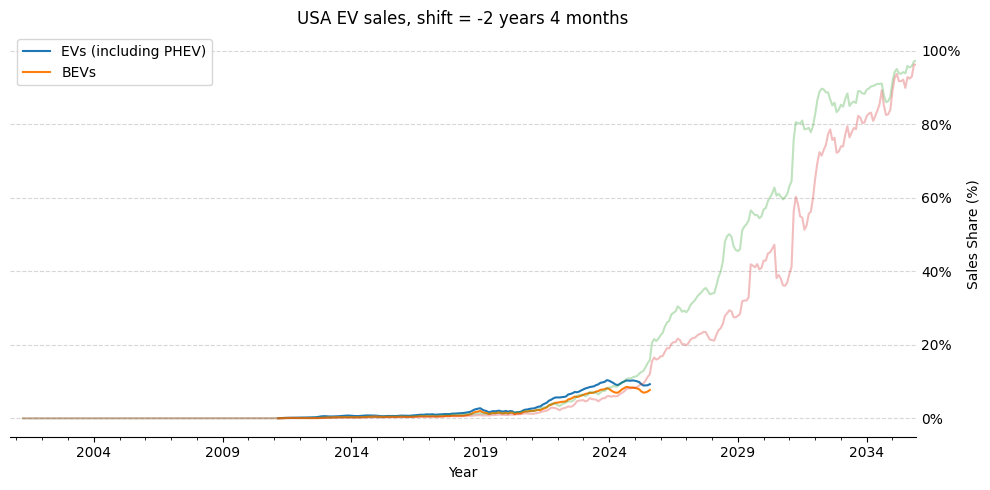

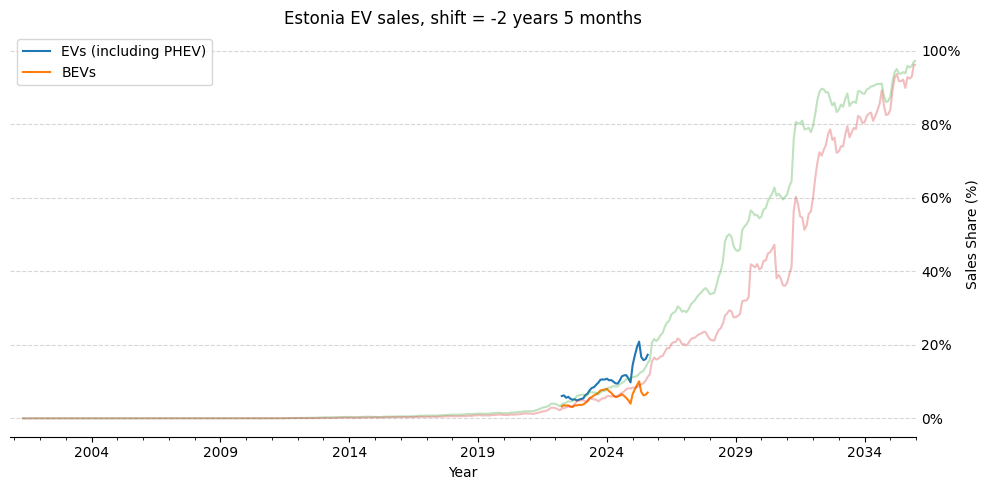

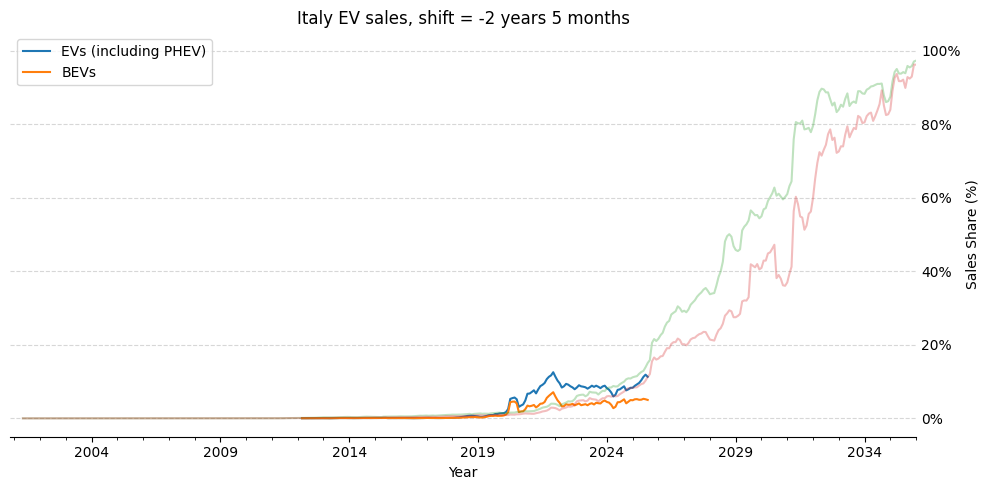

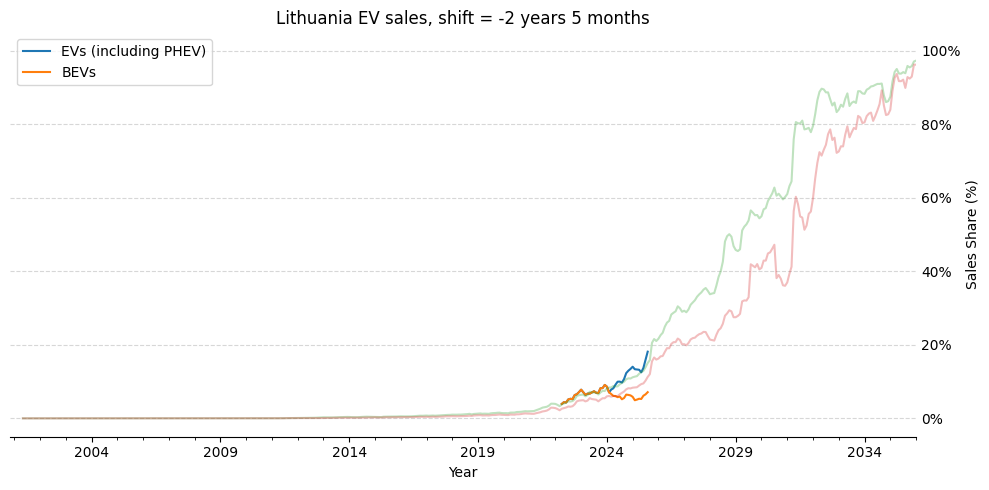

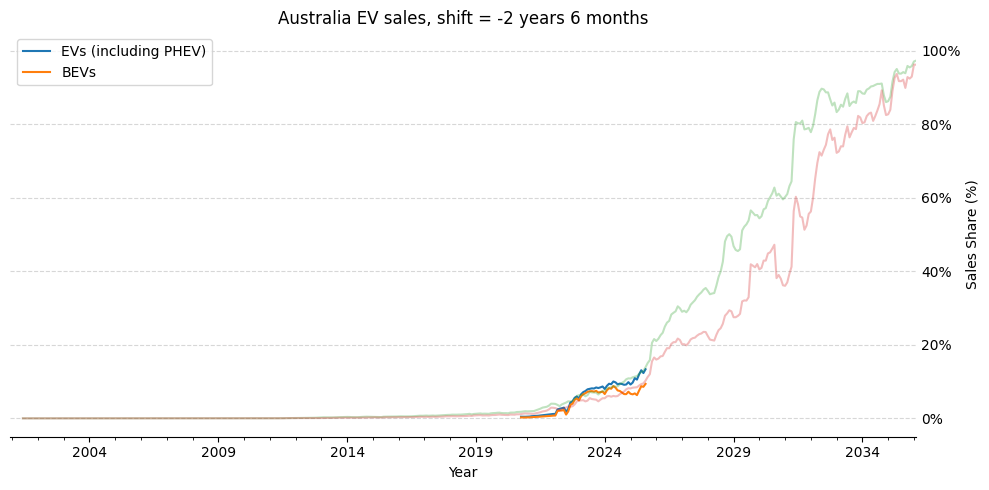

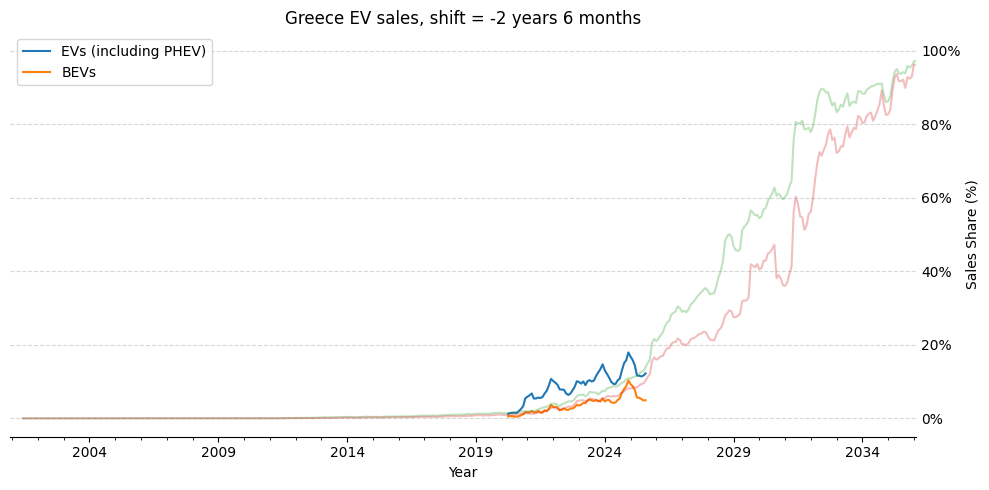

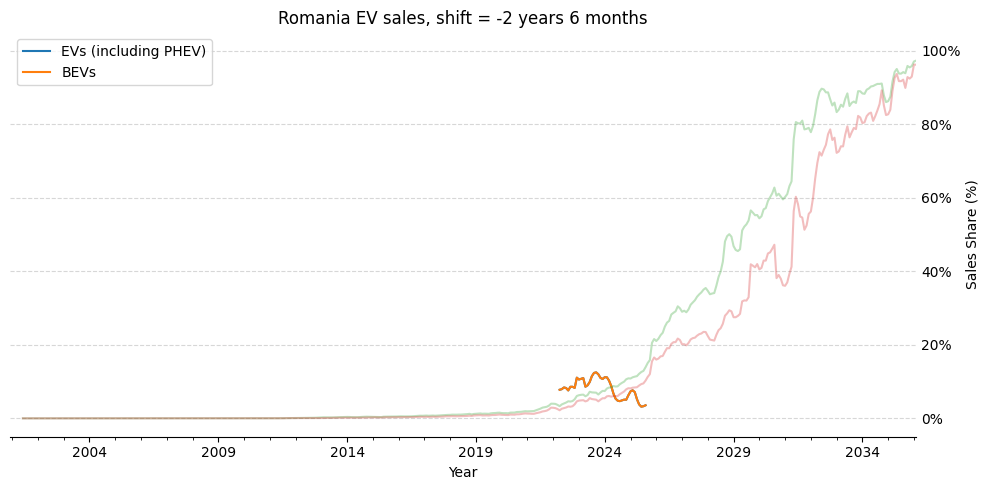

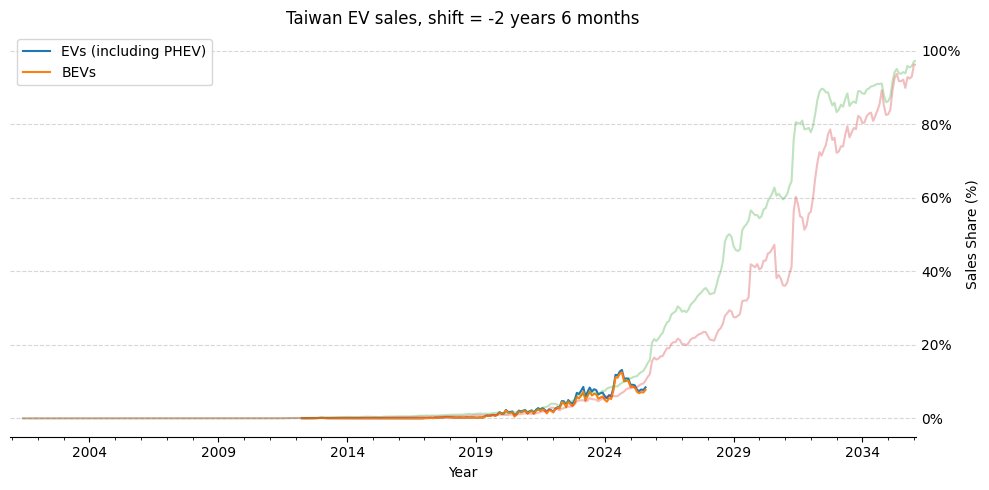

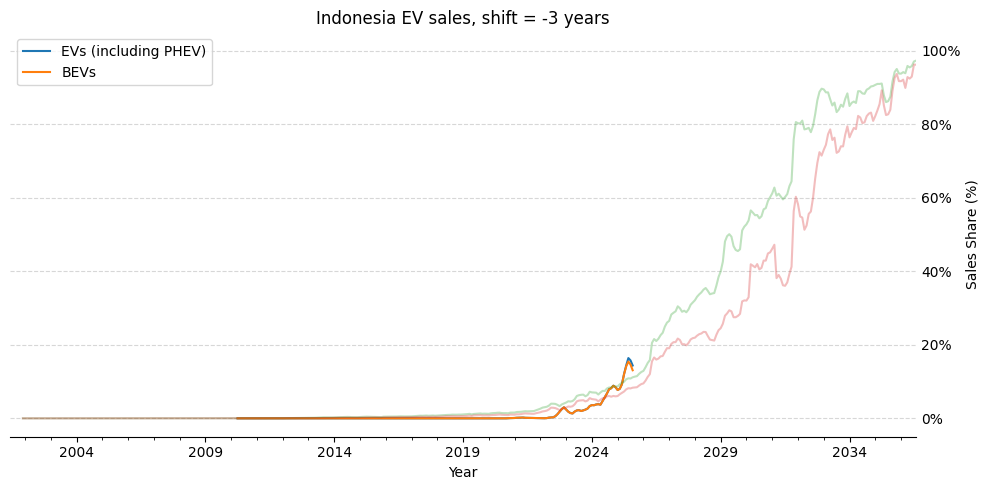

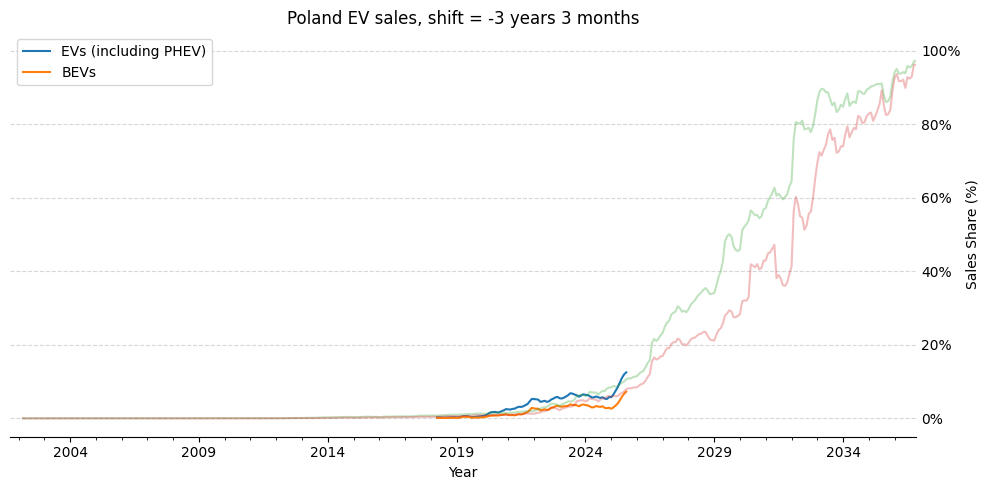

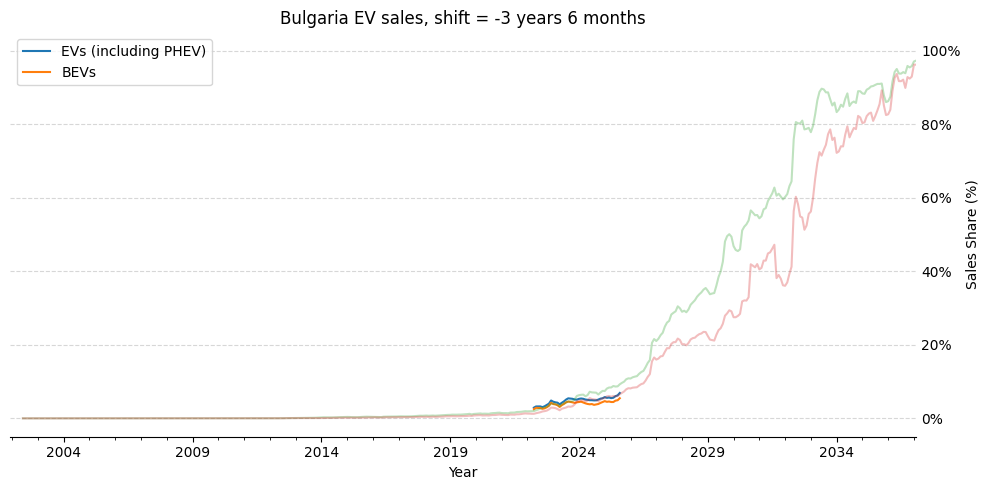

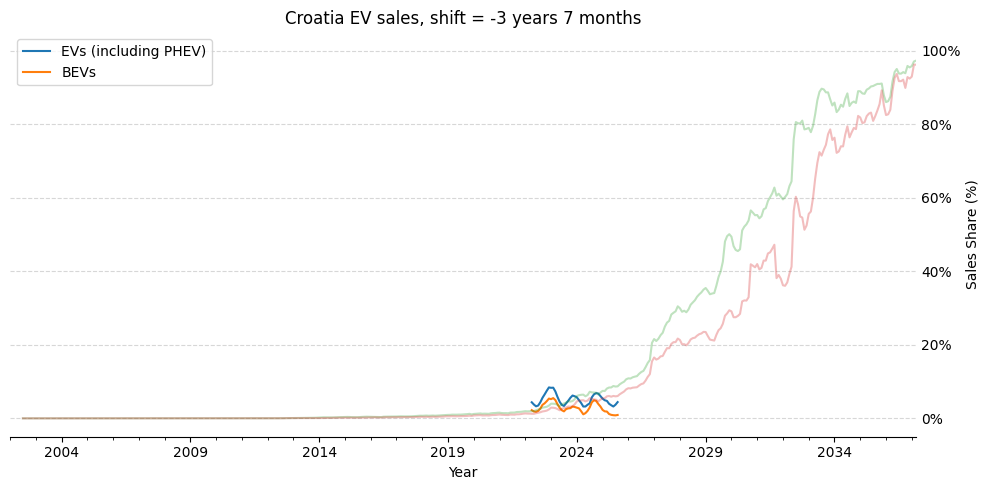

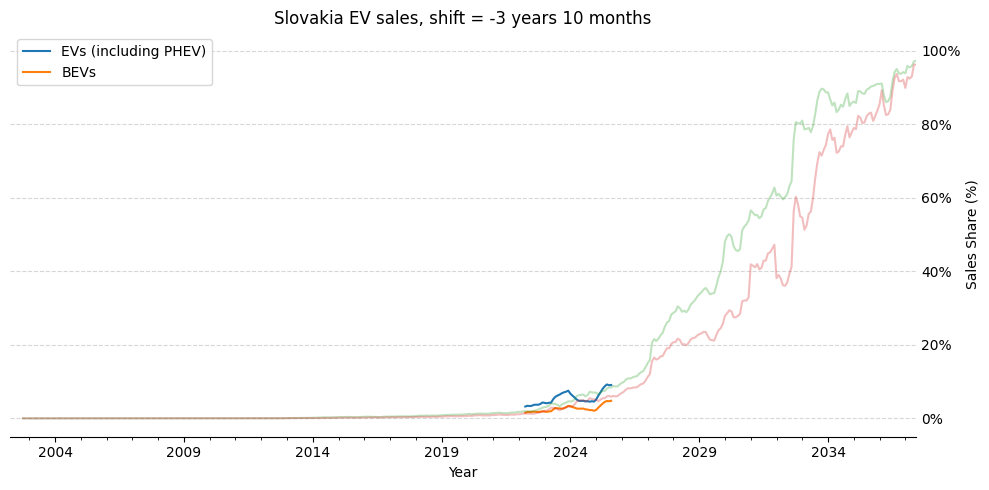

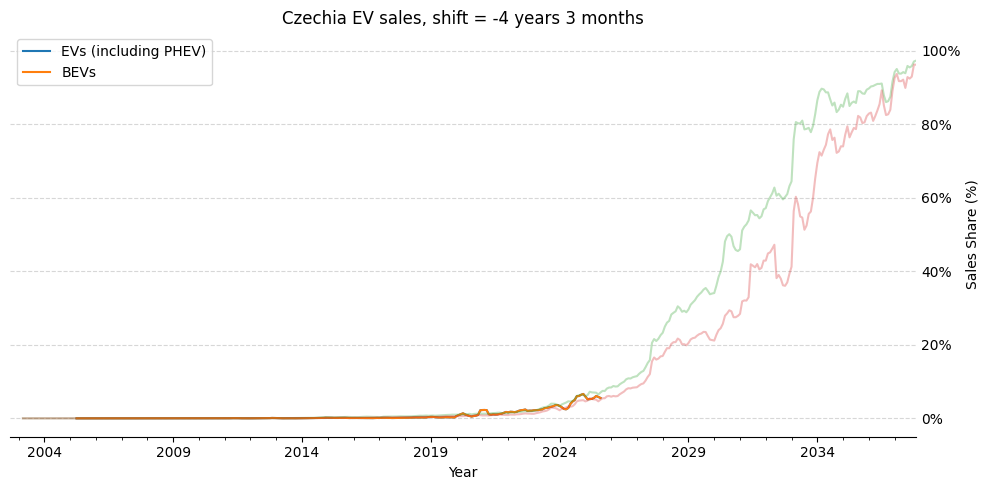

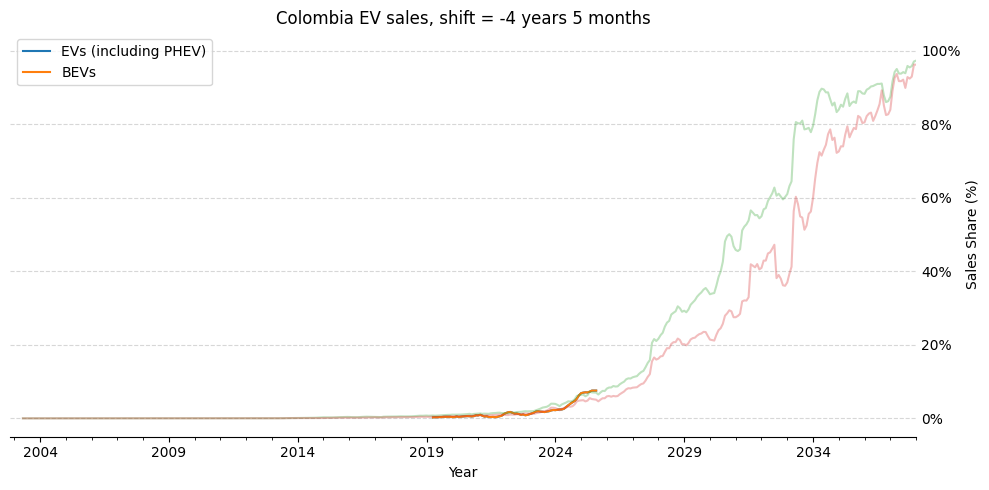

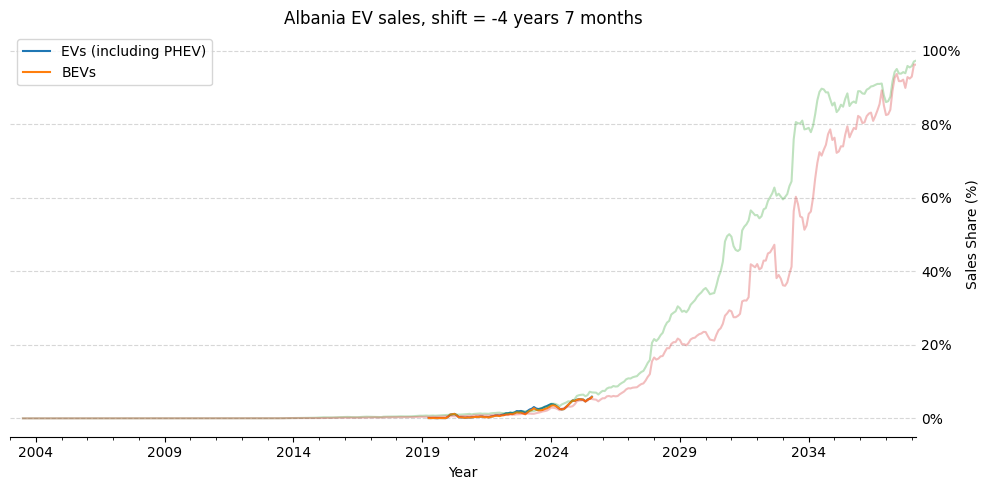

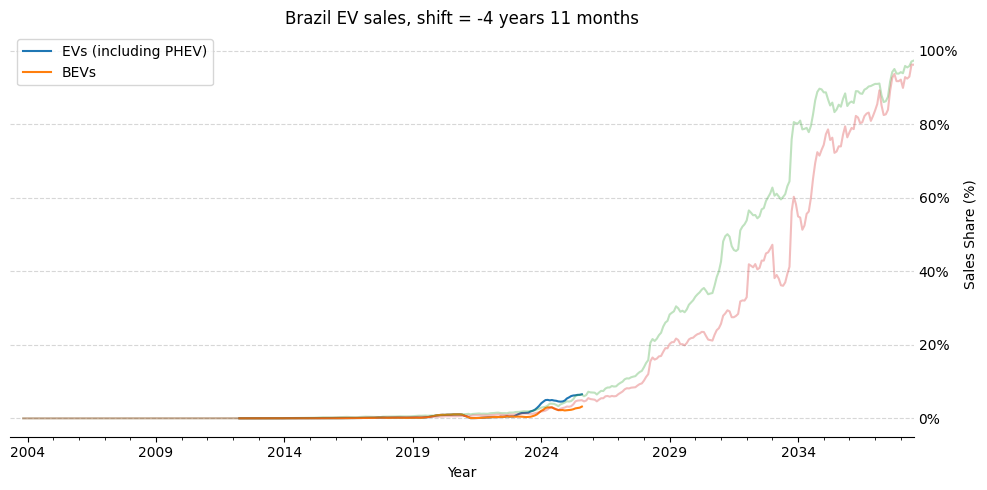

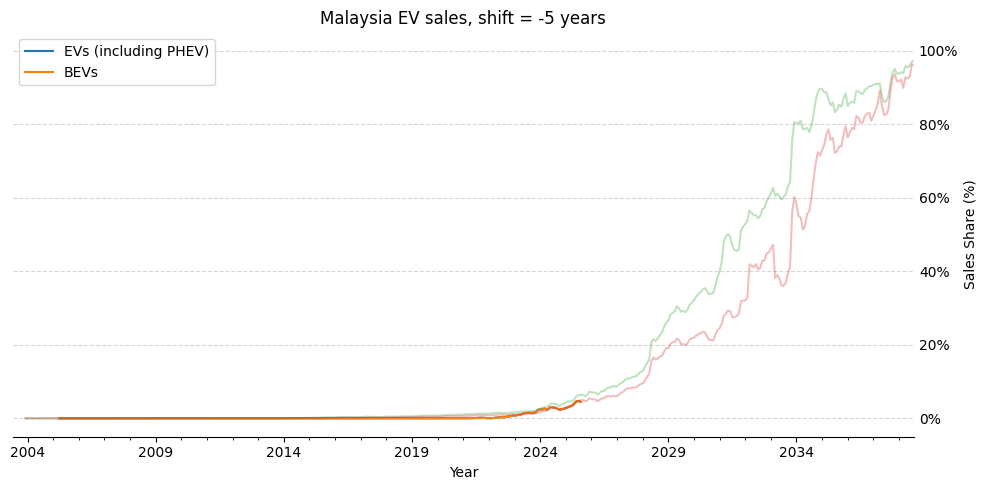

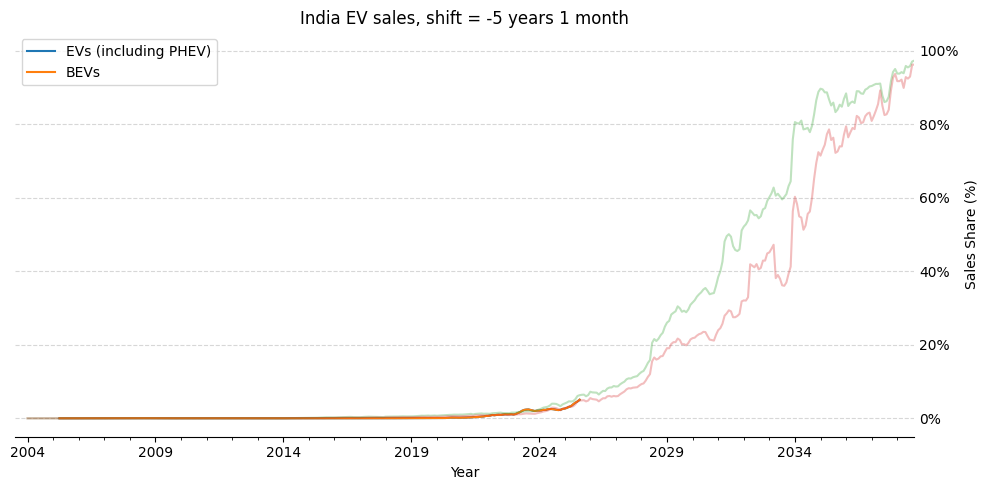

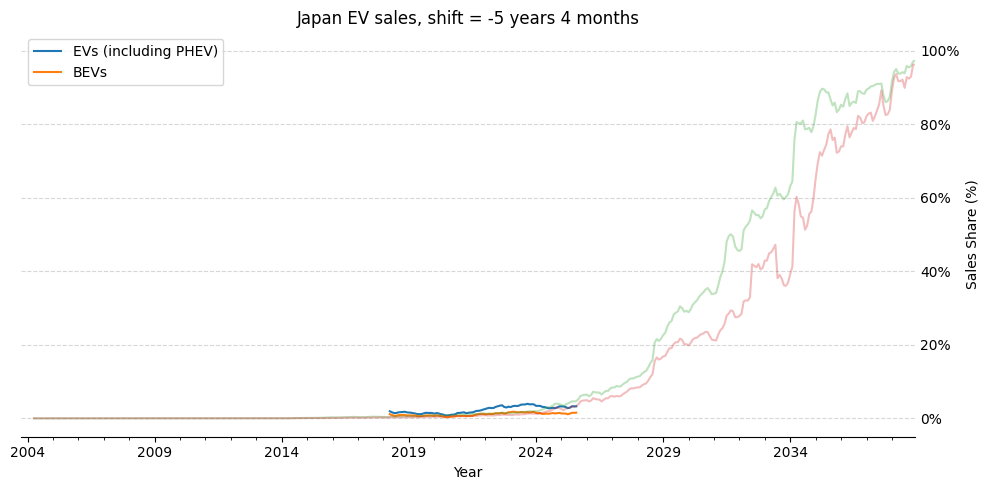

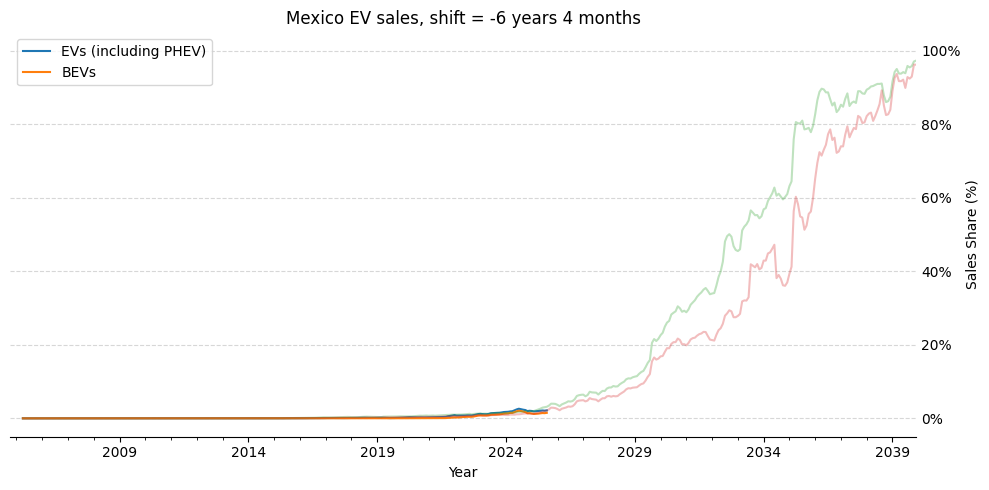

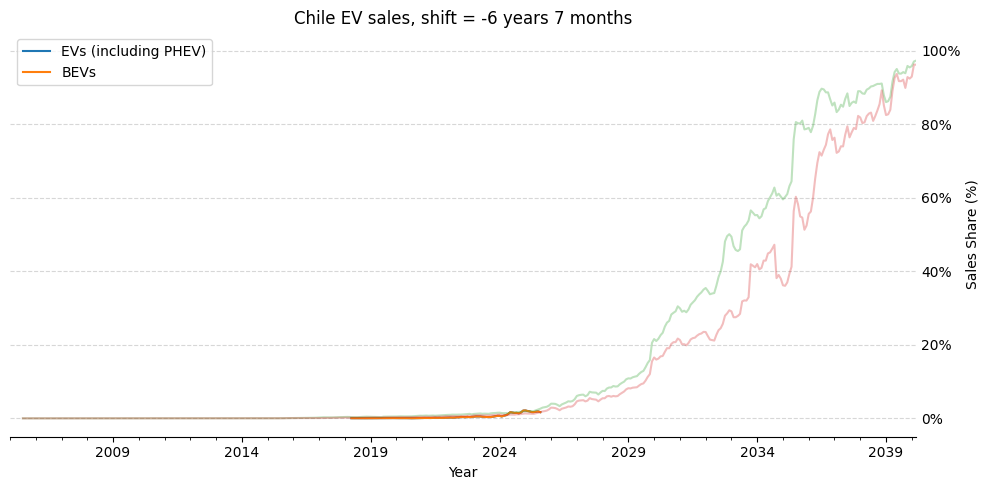

{'Albania': np.int64(-55),
 'Australia': np.int64(-30),
 'Austria': np.int64(7),
 'Belgium': np.int64(13),
 'Brazil': np.int64(-59),
 'Bulgaria': np.int64(-42),
 'California': np.int64(6),
 'Canada': np.int64(-19),
 'Chile': np.int64(-79),
 'China': np.int64(18),
 'Colombia': np.int64(-53),
 'Croatia': np.int64(-43),
 'Cyprus': np.int64(-28),
 'Czechia': np.int64(-51),
 'Denmark': np.int64(30),
 'Estonia': np.int64(-29),
 'Finland': np.int64(28),
 'France': np.int64(5),
 'Germany': np.int64(14),
 'Greece': np.int64(-30),
 'Hungary': np.int64(-28),
 'Iceland': np.int64(49),
 'India': np.int64(-61),
 'Indonesia': np.int64(-36),
 'Ireland': np.int64(16),
 'Israel': np.int64(6),
 'Italy': np.int64(-29),
 'Japan': np.int64(-64),
 'Latvia': np.int64(-27),
 'Lithuania': np.int64(-29),
 'Luxembourg': np.int64(15),
 'Malaysia': np.int64(-60),
 'Malta': np.int64(13),
 'Mexico': np.int64(-76),
 'Netherlands': np.int64(17),
 'New Zealand': np.int64(-28),
 'Norway': np.int64(96),
 'Poland': np.int6

In [8]:


frequency = pd.infer_freq(e_car_sales.index.get_level_values(1).unique().sort_values())
if frequency is None:
    print('Falling back to default frequency: Monthly')
    frequency = 'MS'
#frequency = 'QS'

freq_in_year = frequency_in_year(frequency)


def align_countries_ev_trajectories(e_car_sales=e_car_sales, frequency=frequency, rolling_average=1, verbose=0):
    
    # make sure all the data conforms to the frequency we want
    relevant_sales = e_car_sales
    countries = relevant_sales.index.get_level_values(0).unique()
    dates = relevant_sales.index.get_level_values(1).unique().sort_values()
    min_date, max_date = dates.min(), dates.max()
    dates_index = pd.date_range(min_date, max_date, freq=frequency, normalize=True)
    min_date, max_date = dates_index.min(), dates_index.max()
    #relevant_sales = relevant_sales.reindex(pd.MultiIndex.from_product([countries, dates_index], names=relevant_sales.index.names))
    relevant_sales = relevant_sales.groupby(level=0, group_keys=True).apply(
        lambda g: g.droplevel(0).sort_index().resample(frequency).mean(numeric_only=True).reindex(dates_index).interpolate(
            method='time').rolling(rolling_average).mean()).reindex(pd.MultiIndex.from_product([countries, dates_index], names=relevant_sales.index.names))
    
    freq_in_year = frequency_in_year(frequency)
    
    
    # How many years each country is ahead / behind
    countries_offsets = {c: 0 for c in relevant_sales.index.get_level_values(0).unique()}
    
    for i in range(10):
        
        min_off = min(min(countries_offsets.values()), 0)
        max_off = max(max(countries_offsets.values()), 0)
        #start_date = min_date + pd.Timedelta(min_off, unit=frequency)
        # this seems to be the best method to add a certain number of `frequency` to a given date...
        start_date = pd.date_range(
            end = min_date, 
            periods = -min_off+1, 
            freq = frequency
        )[0]
        
        #end_date = max_date + pd.Timedelta(max_off + 1, unit=frequency)
        end_date = pd.date_range(
            start = max_date, 
            periods = max_off+1, 
            freq = frequency
        )[-1]
        expanded_dates = pd.date_range(start_date, end_date, freq=frequency)
    
        expanded_index = pd.MultiIndex.from_product([countries, expanded_dates], names=relevant_sales.index.names)
        
        #print(expanded_index)
        
        # shift the sales data in every country by the years in country_offsets
        shifted_sales = (
            relevant_sales.reindex(expanded_index)
            .groupby(level=0, group_keys=False)
            .apply(lambda g: g.sort_index(level=1).shift(countries_offsets.get(g.index.get_level_values(0)[0], 0)))
        )
        
    
        # includes PHEV
        mean_ev_sales_share = (
                (shifted_sales[ev.SALES_SHARE_EVS] * shifted_sales[ev.SALES_TOTAL])
                .groupby(level=1).sum()
                /
                shifted_sales[ev.SALES_TOTAL].groupby(level=1).sum()
        ).sort_index().to_frame(name='EV')
    
        mean_bev_sales_share = (
                (shifted_sales[ev.SALES_SHARE_BEVS] * shifted_sales[ev.SALES_TOTAL])
                .groupby(level=1).sum()
                /
                shifted_sales[ev.SALES_TOTAL].groupby(level=1).sum()
        ).sort_index().to_frame(name='BEV')
        
    
    
        a_ev = mean_ev_sales_share['EV'].to_numpy()
        a_bev = mean_bev_sales_share['BEV'].to_numpy()
        for c in countries_offsets:
            v_ev = relevant_sales[ev.SALES_SHARE_EVS].loc[c].to_numpy()
            v_bev = relevant_sales[ev.SALES_SHARE_BEVS].loc[c].to_numpy()
            
            assert len(v_ev) == len(v_bev)
            c_start_date = relevant_sales[ev.SALES_SHARE_BEVS].loc[c].index.min()
            
            base_offset = -len(pd.date_range(
                start = start_date, 
                end = c_start_date, 
                freq = frequency
            )) 
            
            # offsets should be the same
            offsets, correlated_ev = correlate_slice_normalized(a_ev, v_ev)
            _, correlated_bev = correlate_slice_normalized(a_bev, v_bev)
            
            # consider correlation of both EV (includes PHEV) and BEV fractions with an added bias torward 0 offset
            correlated = (correlated_ev + correlated_bev) / 2 - (abs(offsets+base_offset) / len(offsets) * 0.01)
            
            new_shift = offsets[np.argmax(correlated)] + base_offset
            countries_offsets[c] = new_shift
            
            # Debug info for specific countries
            if c in []:
                print('Country data start date: ', c_start_date)
                print('Global data start date: ', start_date)
                print('Global data end date: ', end_date)
                print('Base offset: ', base_offset, 'Calculated Shift: ', new_shift)
                ax = pd.concat([relevant_sales.loc[c][ev.SALES_SHARE_EVS], relevant_sales.loc[c][ev.SALES_SHARE_BEVS]], axis=1).plot(figsize=(8, 4), legend=False)
                ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
                ax.set_title('EV Sales Share')
                ax.set_xlabel('Year')
                ax.set_ylabel('EV Sales Share')
                plt.tight_layout()
                plt.show()
            
                corr_series = pd.concat([
                    pd.Series(correlated, name='Correlation'),
                    pd.Series(correlated_ev, name='EV'),
                    pd.Series(correlated_bev, name='BEV')
                    ], axis=1)
                ax = corr_series.plot(figsize=(8, 2))
                ax.set_title(f'Correlation of {c}')
                plt.tight_layout()
                plt.show()
                
                print('Different maxima: ', np.argmax(correlated), new_shift, offsets[np.argmax(correlated_ev)] + base_offset, offsets[np.argmax(correlated_bev)] + base_offset)
                
                ax = pd.concat([relevant_sales.loc[c][ev.SALES_SHARE_EVS], relevant_sales.loc[c][ev.SALES_SHARE_BEVS]], axis=1).shift(new_shift, freq=frequency).plot(figsize=(8, 4), legend=False)
                ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
                ax.set_title(f'{c}, Shift = {new_shift}')
                ax.set_xlabel('Year')
                ax.set_ylabel('EV Sales Share')
                plt.tight_layout()
                plt.show()
    
    if verbose > 0:
        print('Time shift of all the countries (how many years they are ahead / behind the average transition)')
        display({k: int(v) for k, v in countries_offsets.items()})
    
    
    if verbose > 1:
        ax = shifted_sales[ev.SALES_SHARE_EVS].unstack(level=0).plot(figsize=(10, 5), legend=False, alpha=0.3, color='grey', lw=1)
        ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).rename(columns={'EV': 'EVs (including PHEV)', 'BEV': 'BEVs'}).plot(ax = ax, figsize=(10, 5), legend=True)
        ax.set_title(f'All countries time-shifted EV sales share vs average trajectory')
        ax.set_xlabel('Year (only for average, others are time-shifted)')
        ax.set_ylabel('Sales Share (%)')
        ax.set_ylim(-0.05, 1.05)
        ax.yaxis.set_label_position("right")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
        ax.yaxis.tick_right()
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        plt.tick_params(axis='y', which='major', length=0)
        plt.grid(linestyle='--', alpha=0.5, axis='y')
        plt.tight_layout()
        #plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.png', dpi=300, bbox_inches='tight')
        #plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.svg', dpi=300, bbox_inches='tight')
        plt.show()
    
    
    if verbose > 2:
        for c in sorted(countries_offsets.keys(), key=lambda x: countries_offsets[x], reverse=True):
            ax = relevant_sales.loc[c][ev.SALES_SHARE_EVS].plot(figsize=(10, 5), legend=True, label='EVs (including PHEV)')
            ax = relevant_sales.loc[c][ev.SALES_SHARE_BEVS].plot(ax = ax, figsize=(10, 5), legend=True, label='BEVs')
            ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).shift(-countries_offsets[c], freq=frequency).plot(ax = ax, figsize=(10, 5), alpha=0.3, legend=False)
            ax.set_title(f'{c} EV sales, shift = {delta_frequency_to_string(countries_offsets[c], frequency)}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Sales Share (%)')
            ax.set_ylim(-0.05, 1.05)
            ax.yaxis.set_label_position("right")
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
            ax.yaxis.tick_right()
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            #ax.spines['bottom'].set_visible(False)
            plt.tick_params(axis='y', which='major', length=0)
            plt.grid(linestyle='--', alpha=0.5, axis='y')
            plt.tight_layout()
            #plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.png', dpi=300, bbox_inches='tight')
            #plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.svg', dpi=300, bbox_inches='tight')
            plt.show()
    
    return countries_offsets

align_countries_ev_trajectories(e_car_sales[only_countries], frequency, rolling_average=4, verbose=3)

TODO: In the future, an S-Curve can be fit to this trajectory and parameters can be extracted to understand the speed of the transition

In [9]:
# Loop over dates from 2010 to data max, cut off newer data for each date,
# run alignment on the historical data to generate the index

# Frequency to use
calc_freq = 'QS'

start_dt = pd.Timestamp('2010-01-01')
data_max_dt = e_car_sales.index.get_level_values(1).max()
iter_dates = pd.date_range(start_dt, data_max_dt, freq=calc_freq, normalize=True)

series_list = []
for cutoff_dt in iter_dates:
    # Progressively cut off data newer than cutoff date
    relevant_sales = e_car_sales[only_countries]
    relevant_sales = relevant_sales[relevant_sales.index.get_level_values(1) <= cutoff_dt]

    offsets_dict = align_countries_ev_trajectories(relevant_sales, frequency=frequency, rolling_average=4, verbose=0)

    # Store as a Series named by cutoff date
    series_list.append(pd.Series(offsets_dict, name=cutoff_dt))

# Build combined dataframe: rows = cutoff date, columns = country, values = offset
combined_offsets = pd.DataFrame(series_list).sort_index()


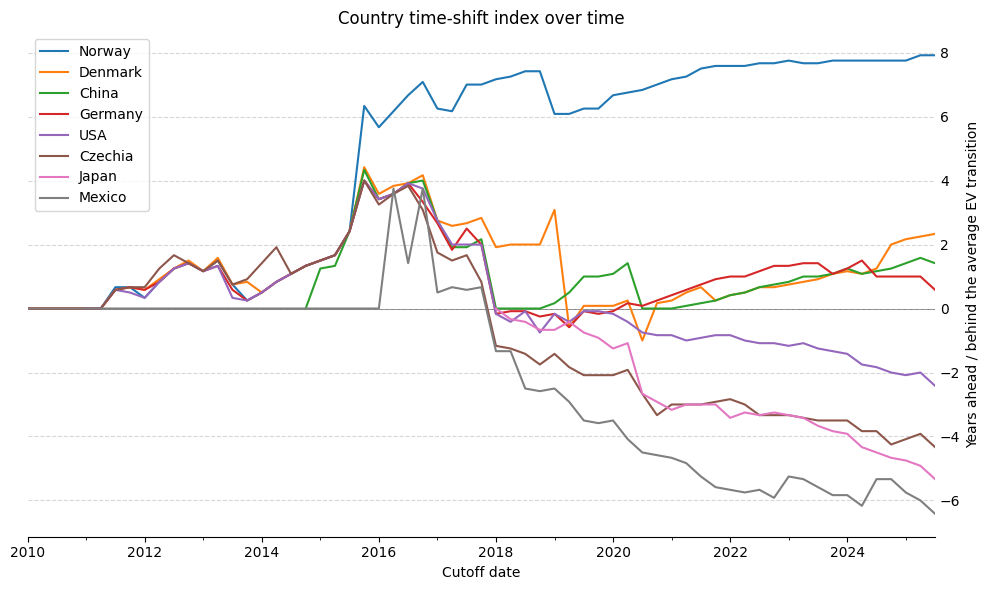

In [10]:
c_to_plot = ['Germany', 'Denmark', 'Norway', 'USA', 'China', 'Mexico', 'Japan', 'Czechia']

# Sort selected countries by their latest value in combined_offsets descending
cols = [c for c in c_to_plot if c in combined_offsets.columns]
cols = combined_offsets.iloc[-1][cols].sort_values(ascending=False).index.tolist()

ax = (combined_offsets[cols] / freq_in_year).plot(figsize=(10, 6), legend=True, zorder=2)
ax.set_title('Country time-shift index over time')
ax.set_xlabel('Cutoff date')
ax.set_ylabel('Years ahead / behind the average EV transition')
#ax.set_ylim(-10, 10)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='y', which='major', length=0)
plt.grid(linestyle='--', alpha=0.5, axis='y')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.7, alpha=1, zorder=1)

plt.tight_layout()
plt.show()


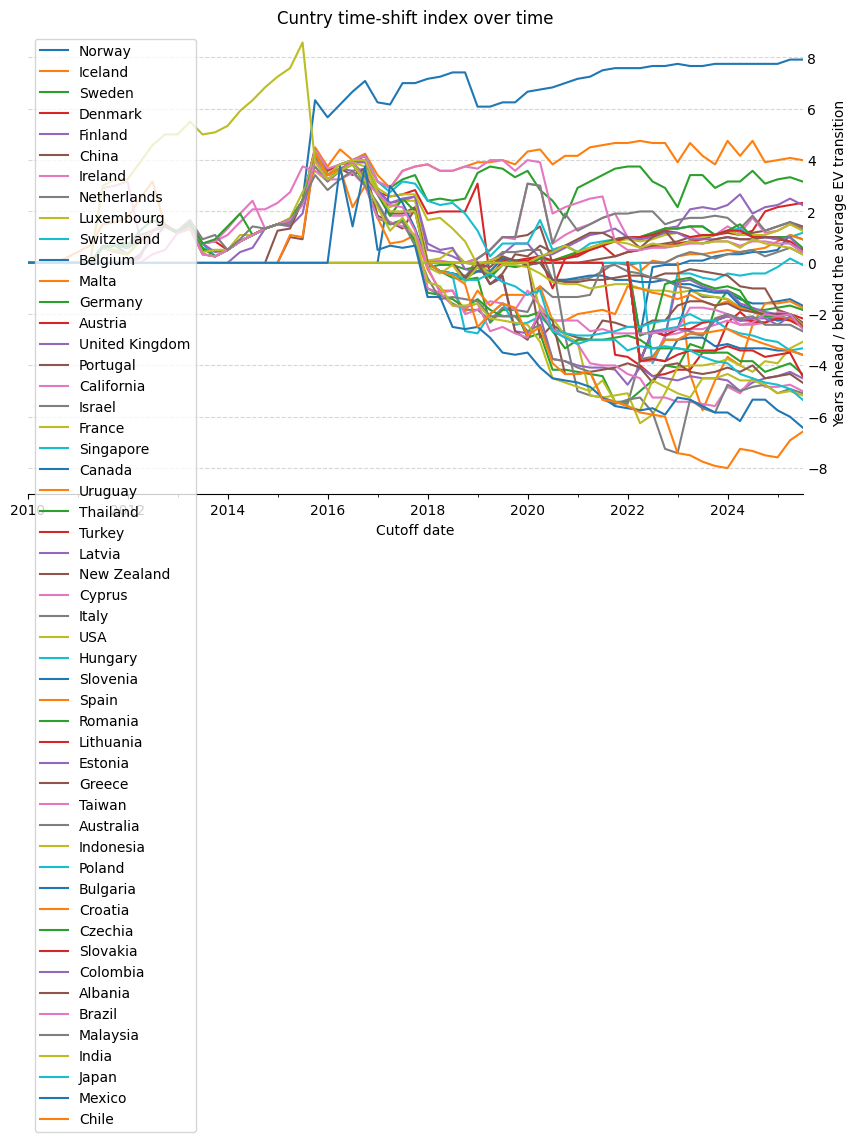

In [12]:

order = combined_offsets.iloc[-1].sort_values(ascending=False).index
ax = (combined_offsets[order] / freq_in_year).plot(figsize=(10, 6), legend=True)
ax.set_title('Cuntry time-shift index over time')
ax.set_xlabel('Cutoff date')
ax.set_ylabel('Years ahead / behind the average EV transition')
ax.set_ylim(-9, 9)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='y', which='major', length=0)
plt.grid(linestyle='--', alpha=0.5, axis='y')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.7, alpha=1, zorder=1)

#plt.tight_layout()
plt.show()
